# README

**Make sure to read the project [README.md](README.md) before using this file**

This file plots the results from experiment `experiment11-article2` defined by configuration file [experiment11-article2.csv](experiments/BICY2020_modified/config_files/experiment11-article2.csv).
Make sure you to run the full experiment before using this file, otherwise the results database will not be generated.  
After running the experiment, the following expected folder structure should have been automatically generated:
```
experiments/BICY2020_modified/logs/experiment11-article2
└── mazes                      # folder containing all mazes used
|   |   mazeMetrics.csv        # contains shortest path distances
└── experiments                # contains all setup files used
|   experiment_results.sqlite  # database with results from all rats
|   configs.csv                # configuration file
```  

**NOTE** you may want to open the following files to see their content and to make sure they exist.
- [results database](experiments/BICY2020_modified/logs/experiment11-article2/experiment_results.sqlite) (requires sqlite viewer)
- [configs file](experiments/BICY2020_modified/logs/experiment11-article2/configs.csv)
- [maze metrics file](experiments/BICY2020_modified/logs/experiment11-article2/) 
- [distribution metrics file](experiments/pc_layers/layer_metrics.csv)


# SET UP

1. Import libraries
2. Define default plotting options
3. Create functions to be used throughout file
4. Open database and load configuration file

## IMPORTS

In [3]:
import os, sys, git, time, ntpath, tracemalloc, sqlite3, pandas as pd, numpy as np
from pandas.api.types import CategoricalDtype
from scripts.log_processing.plotting import *
# from scripts.log_processing import data_loader as loader

# DO NOT IMPORT IN REAL SCRIPT:
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, Markdown

from scripts.utils.MazeParser import parse_maze


%matplotlib inline 
#widget

## DEFAULT PLOTTING THEMES AND USEFUL FUNCTIONS

In [4]:
# Function to reset default plotting options
def reset_gg_defaults():
    theme_default = theme_gray() + theme (
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
    )


    theme_set(theme_default)

reset_gg_defaults()

# function to plot pairwise posthoc tests as heat maps
def plot_pairwise_posthoc_test(p_values,p_limit):
    # melts the dataframe with pvalues and plots heatmap (columns and indexes should be the groups as in the result of scikit posthoc dunn test)
    melted = p_values.melt(ignore_index = False).reset_index().set_axis(['group1','group2','p value'], axis=1)
    melted.group1 = melted.group1.astype('category')
    melted.group2 = melted.group2.astype('category')
    # display(melted)
    p0 = ggplot(melted, aes('group1', 'group2', fill='p value'))
    p0 += geom_tile()
    p0 += scale_fill_gradientn(colors = ['green','yellowgreen','lightcoral','red'] , values = [0,p_limit,p_limit + 1e-7,1])
    return p0

## Functions

In [3]:
# Get the last sampled episode
def lastEpisode(configs, sample_rate):
    num_episodes = configs['numEpisodes'].max() / configs['numStartingPositions'].max()
    last_episode = -sample_rate % num_episodes
    return last_episode

# get the data from all rats for a single episode as well as the results aggregated by configuration for all episodes
def getDataEpisodeAndSummaries(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET SUMMARIZED RUNTIME DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location), configs, fields_to_add)

    # GET EPISODE DATA:
    runtimes_episode = None if skip_runtimes else augment_data(load_episode_runtimes(db, indices, location, episode), configs, fields_to_add)
            
    return summaries, runtimes_episode

# calculate the learning time for each rat
def getLearningTimes(db, configs, location, threshold, fields_to_add):
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    runtimes_all_episodes = load_all_runtimes_smaller_than_threshold(db, indices, location, threshold)  
    
    # learning rat defined as min episode with error < threshold
    learning_times = runtimes_all_episodes.loc[runtimes_all_episodes.groupby(['config', 'location', 'rat'])['episode'].idxmin()]
    
    return augment_data(learning_times, configs, fields_to_add)

# add columns `fields` from configs to data by merging both tables
def augment_data(data, configs, fields):
    return pd.merge(data, configs[ ['c_id'] + fields ], left_on='config', right_on='c_id', how='left')
    

## SET EXPERIMENT AND LOAD DATABASE

In [5]:
folder = 'experiments/BICY2020_modified/logs/experiment11-article2/' # experiment log folder
figure_folder = folder + 'figures/' # folder where to store the figures
make_folder(figure_folder) # create folders if they dont exist

git_root = './' # root folder of the git repository
layers_folder = 'experiments/pc_layers/' # folder that contains the distributions (a.k.a. layers)
layer_metrics_file = os.path.join(git_root, layers_folder + 'layer_metrics.csv') # file that contains metrics about the distributions 

sample_rate = 5 # episde frequency at which results where sampled (to reduce storage requirements)
db = sqlite3.connect(folder + 'experiment_results.sqlite')


In [6]:
min_layers = ['u04_40', 'u08_21', 'u12_14', 'u16_11', 'u20_09', 'u24_07', 'u28_06', 'u32_06', 'u36_06', 'u40_05', 'u44_05', 'u48_04', 'u52_04', 'u56_04'] # minimal coverage layers

# ADD COLUMNS TO CONFIGS
configs = load_config_file(folder)
configs['c_id'] = configs.index.map(lambda v : int(v[1:]))
configs['pc_files'] = configs.pc_files.map(os.path.normpath )
configs['pcs'] = configs.pc_files.map(lambda v : ntpath.basename(v)[0:-4])
configs['maze']= configs.mazeFile.map(lambda v : ntpath.basename(v)[0:-4])

# GET LAYER METRICS 
layer_metrics = pd.read_csv(layer_metrics_file)
layer_metrics['layer'] = layer_metrics.layer.map(lambda l : os.path.normpath(layers_folder + l) ) # normalize path and prepend location
layer_metrics['simple_name'] = layer_metrics.layer.map(lambda l : os.path.basename(l) )
layer_metrics['normalized mean distance density'] = 1 / layer_metrics['normalized mean distance']
layer_metrics['normalized coverage'] = layer_metrics['coverage'] * layer_metrics['number of cells']
layer_metrics['num_cells'] = layer_metrics['number of cells']

# f'CONFIG COLUMNS {configs.columns.values}', 'CONFIGS:', configs, 'LAYER METRICS:', layer_metrics
display(configs)
display(layer_metrics)

experiment group  mazeFile  \
config                                                        
c0      experiments/setups/experiment_1.xml    g1    M0.xml   
c1      experiments/setups/experiment_1.xml    g1    M0.xml   
c2      experiments/setups/experiment_1.xml    g1    M0.xml   
c3      experiments/setups/experiment_1.xml    g1    M0.xml   
c4      experiments/setups/experiment_1.xml    g1    M0.xml   
...                                     ...   ...       ...   
c13159  experiments/setups/experiment_1.xml    g1  M607.xml   
c13160  experiments/setups/experiment_1.xml    g1  M608.xml   
c13161  experiments/setups/experiment_1.xml    g1  M608.xml   
c13162  experiments/setups/experiment_1.xml    g1  M609.xml   
c13163  experiments/setups/experiment_1.xml    g1  M609.xml   

        numStartingPositions  \
config                         
c0                         7   
c1                         7   
c2                         7   
c3                         7   
c4                         7   
...                      ...   
c13159                     4   
c13160                     4   
c13161                     4   
c13162                     4   
c13163                     4   

                                                pc_files  traces  numEpisodes  \
config                                                                          
c0              experiments\pc_layers\uniform\u04_40.csv     0.0        70000   
c1              experiments\pc_layers\uniform\u04_40.csv     0.7        70000   
c2              experiments\pc_layers\uniform\u08_21.csv     0.0        70000   
c3              experiments\pc_layers\uniform\u08_21.csv     0.7        70000   
c4              experiments\pc_layers\uniform\u08_25.csv     0.0        70000   
...                                                  ...     ...          ...   
c13159  experiments\pc_layers\multi_layer\ml_4_16_52.csv     0.7        40000   
c13160  experiments\pc_layers\multi_layer\ml_4_16_52.csv     0.0        40000   
c13161  experiments\pc_layers\multi_layer\ml_4_16_52.csv     0.7        40000   
c13162  experiments\pc_layers\multi_layer\ml_4_16_52.csv     0.0        40000   
c13163  experiments\pc_layers\multi_layer\ml_4_16_52.csv     0.7        40000   

         c_id         pcs  maze  
config                           
c0          0      u04_40    M0  
c1          1      u04_40    M0  
c2          2      u08_21    M0  
c3          3      u08_21    M0  
c4          4      u08_25    M0  
...       ...         ...   ...  
c13159  13159  ml_4_16_52  M607  
c13160  13160  ml_4_16_52  M608  
c13161  13161  ml_4_16_52  M608  
c13162  13162  ml_4_16_52  M609  
c13163  13163  ml_4_16_52  M609  

[13164 rows x 10 columns]

layer  number of cells  \
0    experiments\pc_layers\locally_uniform\lu0_20_1...              126   
1    experiments\pc_layers\locally_uniform\lu0_24_1...               79   
2    experiments\pc_layers\locally_uniform\lu0_28_1...               63   
3    experiments\pc_layers\locally_uniform\lu0_32_1...               63   
4    experiments\pc_layers\locally_uniform\lu0_36_1...               63   
..                                                 ...              ...   
122           experiments\pc_layers\uniform\u56_20.csv              560   
123           experiments\pc_layers\uniform\u56_25.csv              875   
124           experiments\pc_layers\uniform\u56_30.csv             1230   
125           experiments\pc_layers\uniform\u56_35.csv             1680   
126           experiments\pc_layers\uniform\u56_40.csv             2200   

      total area  mean area  mean radius  mean distance  \
0      15.426477   0.122432     0.197143       1.502259   
1      13.390725   0.169503     0.230886       1.537851   
2      14.024070   0.222604     0.262857       1.556019   
3      18.095574   0.287231     0.297143       1.556019   
4      22.709945   0.360475     0.331429       1.556019   
..           ...        ...          ...            ...   
122   551.713935   0.985203     0.560000       1.424010   
123   862.053024   0.985203     0.560000       1.411379   
124  1211.800251   0.985203     0.560000       1.403663   
125  1655.141806   0.985203     0.560000       1.397716   
126  2167.447604   0.985203     0.560000       1.393318   

     normalized mean distance    coverage    simple_name  \
0                    7.620153    1.931590  lu0_20_16.csv   
1                    6.660649    1.584301  lu0_24_16.csv   
2                    5.919638    1.596487  lu0_28_16.csv   
3                    5.236603    2.053446  lu0_32_16.csv   
4                    4.694885    2.571332  lu0_36_16.csv   
..                        ...         ...            ...   
122                  2.542874   65.843517     u56_20.csv   
123                  2.520319  103.768336     u56_25.csv   
124                  2.506540  146.620107     u56_30.csv   
125                  2.495921  201.059767     u56_35.csv   
126                  2.488068  264.099372     u56_40.csv   

     normalized mean distance density  normalized coverage  num_cells  
0                            0.131231           243.380355        126  
1                            0.150136           125.159817         79  
2                            0.168929           100.578684         63  
3                            0.190964           129.367085         63  
4                            0.212998           161.993939         63  
..                                ...                  ...        ...  
122                          0.393256         36872.369518        560  
123                          0.396775         90797.294224        875  
124                          0.398956        180342.732152       1230  
125                          0.400654        337780.409285       1680  
126                          0.401918        581018.617351       2200  

[127 rows x 12 columns]

# Experiment 11

## Locally uniform experiment

In [49]:
# CHOOSE PARAMETERS
mazes = ['M0.xml', 'M1.xml']
traces = [0 ,0.7]
m = mazes
t = traces[0]

# CREATE FOLDERS FOR EXPERIMENT
folder_lu = os.path.join(figure_folder,'locally_uniform/')
folder_lu_runtimes = os.path.join(folder_lu, 'runtimes/')
make_folder(folder_lu)
make_folder(folder_lu_runtimes)


# GENERATE CATEGORIES FOR DATA
categories = ['original', 'goal', 'goal and gap']
categories = CategoricalDtype(categories[0:-1] if m == 'M0' else categories , ordered=True)

# GET CONFIGS RELEVANT TO EXPERIMENT
experiment_configs = configs[ configs.mazeFile.isin(mazes) & ( configs.traces.isin(traces) ) & configs.pc_files.str.contains('|'.join(['lu'] + min_layers[4:])) ].copy()
experiment_configs['base layer'] = experiment_configs.pcs.map(lambda l : re.findall('\d+', l)[-2])
experiment_configs['legend groups'] = experiment_configs.pcs.map(lambda l : 'original' if l[0]=='u' else 'goal' if l[2] == '0' else 'goal and gap').astype(categories)
experiment_configs['trace'] = experiment_configs.traces.apply(lambda x : f'{x:.1f}')

# GET AND AUGMENT DATA
merge_fields = ['base layer', 'legend groups', 'maze', 'trace']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)


# DISPLAY
# display('CATEGORIES: ', categories)
# display(experiment_configs[['mazeFile','pcs','traces','base layer','legend groups']])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(learning_times)

config  location  rat  episode  steps   c_id base layer legend groups  \
0         40       255    0      105   0.96     40         20      original   
1         40       255    1      100   0.76     40         20      original   
2         40       255    2       70   0.87     40         20      original   
3         40       255    3       80   1.00     40         20      original   
4         40       255    4       90   1.00     40         20      original   
...      ...       ...  ...      ...    ...    ...        ...           ...   
9995   13037       255   95       30   0.86  13037         56  goal and gap   
9996   13037       255   96       25   0.80  13037         56  goal and gap   
9997   13037       255   97       15   0.84  13037         56  goal and gap   
9998   13037       255   98       20   0.56  13037         56  goal and gap   
9999   13037       255   99       15   0.94  13037         56  goal and gap   

     maze trace  
0      M0   0.0  
1      M0   0.0  
2      M0   0.0  
3      M0   0.0  
4      M0   0.0  
...   ...   ...  
9995   M1   0.7  
9996   M1   0.7  
9997   M1   0.7  
9998   M1   0.7  
9999   M1   0.7  

[10000 rows x 10 columns]

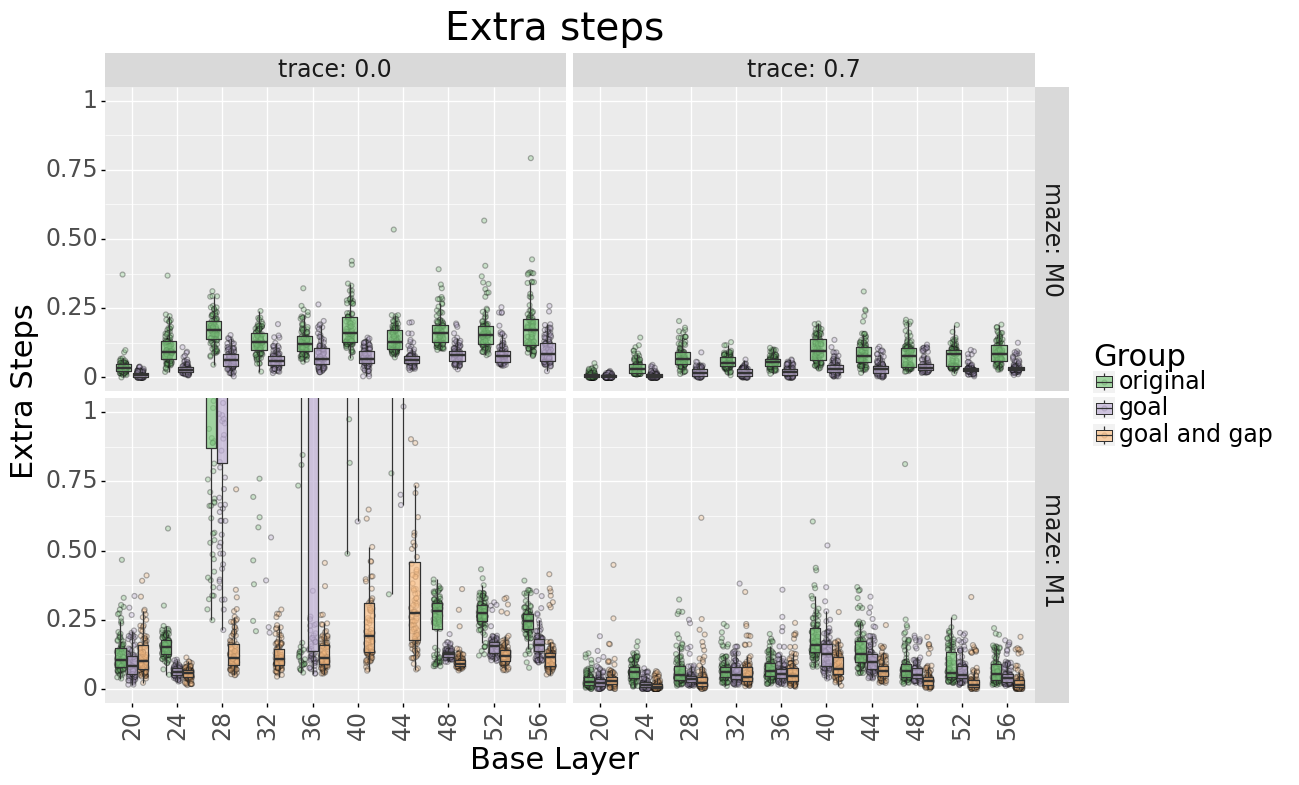

<ggplot: (118389275459)>

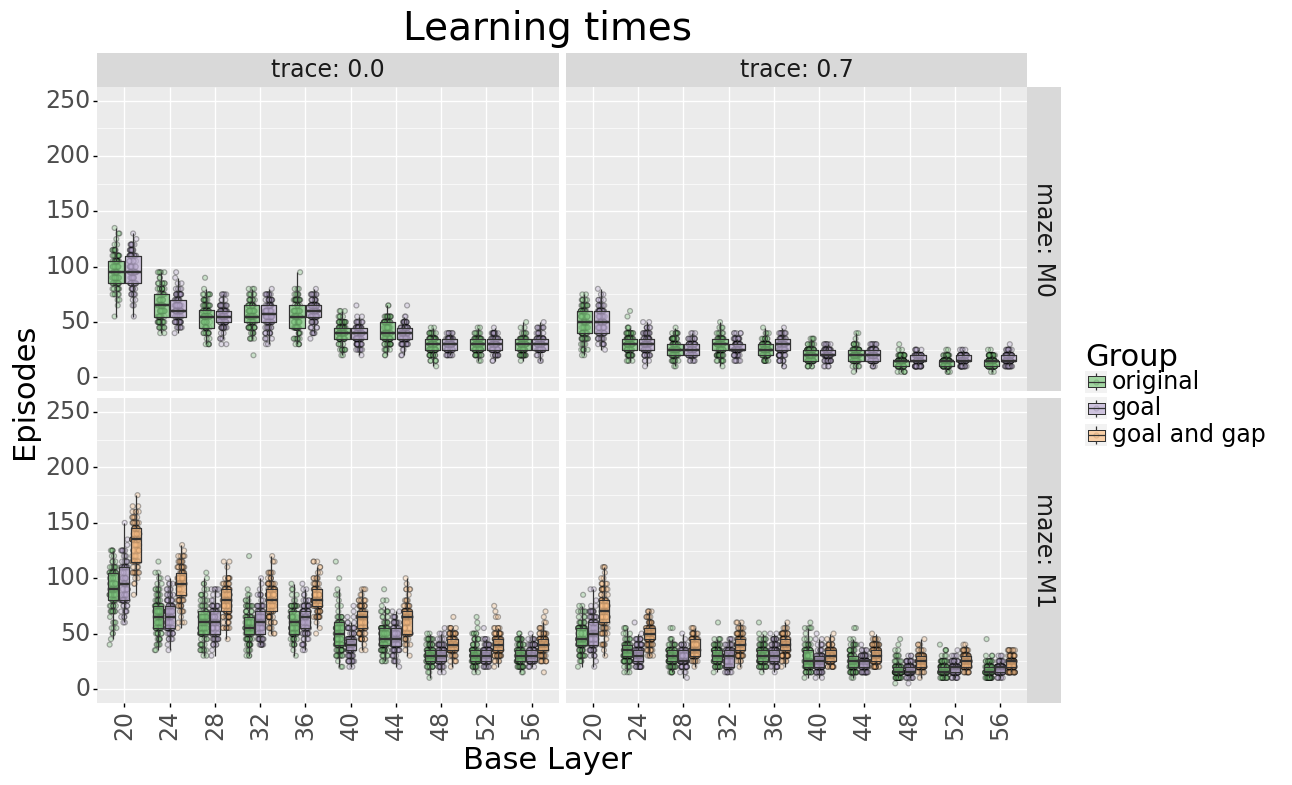

<ggplot: (118385533633)>

config  location  episode  steps   c_id base layer legend groups maze  \
0           40       255        0  24.03     40         20      original   M0   
1           40       255        5  11.82     40         20      original   M0   
2           40       255       10   7.93     40         20      original   M0   
3           40       255       15   6.84     40         20      original   M0   
4           40       255       20   5.57     40         20      original   M0   
...        ...       ...      ...    ...    ...        ...           ...  ...   
199995   13037       255     9975   0.01  13037         56  goal and gap   M1   
199996   13037       255     9980   0.02  13037         56  goal and gap   M1   
199997   13037       255     9985   0.01  13037         56  goal and gap   M1   
199998   13037       255     9990   0.01  13037         56  goal and gap   M1   
199999   13037       255     9995   0.01  13037         56  goal and gap   M1   

       trace  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
199995   0.7  
199996   0.7  
199997   0.7  
199998   0.7  
199999   0.7  

[200000 rows x 9 columns]

    Plot layer: 24   -   file: runtimes-M1-T0.0-L24-y1-x500.pdf


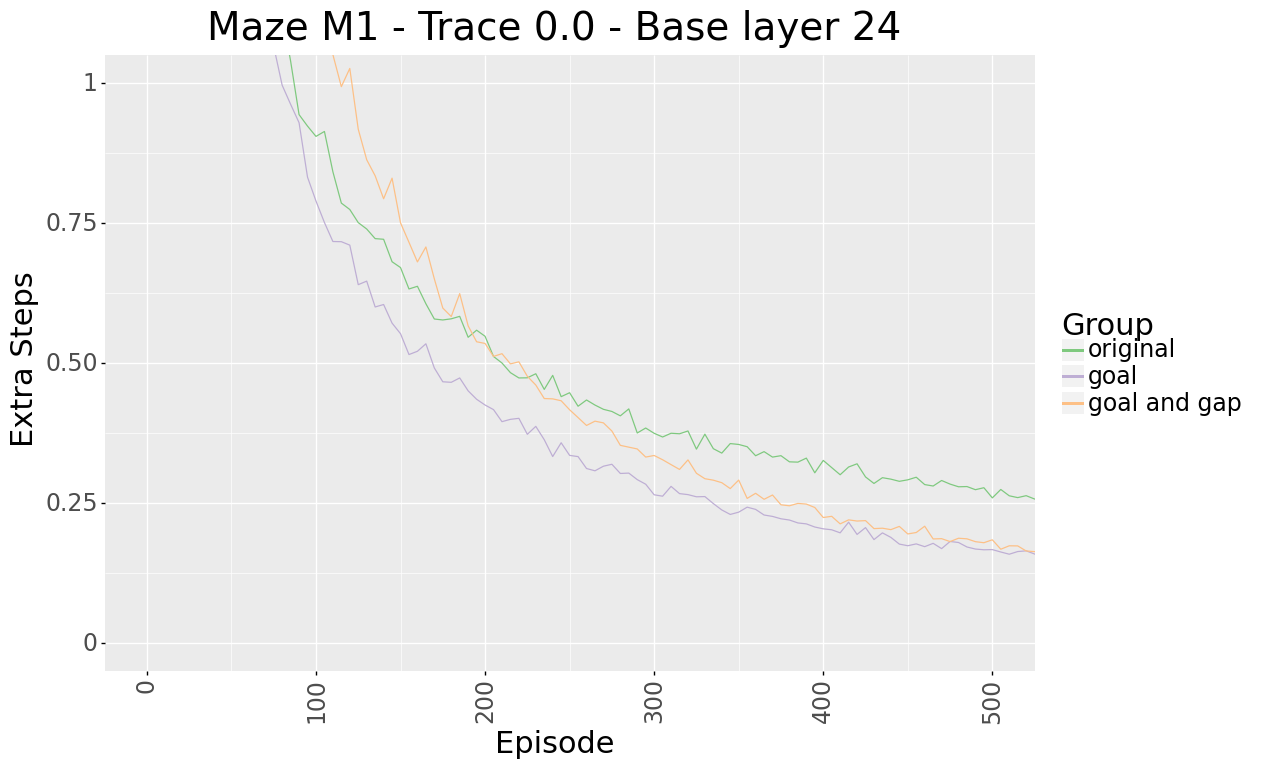

<ggplot: (118382220560)>

In [51]:
# PLOT FUNCTIONS
reset_gg_defaults()

def plot_grouped_box_plot(data, x_column, y_column, fill_column, x_title, y_title, legend_title, plot_title, ylim):
    p0 = ggplot(data, aes(x_column, y_column, fill=fill_column ))
    p0 += facet_grid(f'maze ~ trace', scales='free_x', labeller='label_both')
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(dodge_width=0.75), mapping=aes(group=fill_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=legend_title)
    p0 += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5),
        figure_size = (12,8)
    )
    p0 += scale_fill_brewer(type="qual", palette=1)
    p0 += coord_cartesian(ylim=ylim)              
    return p0

def plot_time_series(data, x_column, y_column, color_column, x_title, y_title, legend_title, plot_title, xlim, ylim):
    p0 = ggplot(data, aes(x_column, y_column, color=color_column))
    p0 += geom_line()
    p0 += labs(x=x_title, y=y_title, color=legend_title, title=plot_title, caption='smt')
    p0 += coord_cartesian(ylim=ylim, xlim=xlim)
    p0 += scale_color_brewer(type="qual", palette=1) 
    return p0


# plt.close('all')

# PLOT EXTRA STEP RATIOS
group_name = f'{m}'
plot_title = f'Extra steps'
ylim = [0, 1]
plot = plot_grouped_box_plot(runtimes_last_episode, 'base layer', 'steps', 'legend groups', 'Base Layer', 'Extra Steps', 'Group', plot_title, ylim)
display(plot)
ggsave(plot, folder_lu + f'e3_extra_steps-l{ylim[1]}MST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_lu + f'e3_extra_steps-l{ylim[1]}MST.png', dpi=300, verbose = False)


# PLOT LEARNING TIME
group_name = f'{m}'
plot_title = f'Learning times'
ylim = [0, 250]
plot = plot_grouped_box_plot(learning_times, 'base layer', 'episode', 'legend groups', 'Base Layer', 'Episodes', 'Group', plot_title, ylim)
display(plot)
ggsave(plot, folder_lu + f'e3_learn_time-l{ylim[1]}-Th{threshold}MST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_lu + f'e3_learn_time-l{ylim[1]}-Th{threshold}MST.png', dpi=300, verbose = False)



# PLOT EXTRA STEP RATIOS TIME SERIES for single base layer- ONLY ONE BASE LAYER PER PLOT
base_layer = '24'
t = '0.0'
m = 'M1'
display(summaries)
plot_data = summaries[(summaries['base layer']==base_layer) & (summaries.trace == t) & (summaries.maze == m)]

group_name = f'{m}'
plot_title = f'Maze {m} - Trace {t} - Base layer {base_layer}'
xlim = [0, 500]
ylim = [0, 1]

save_name = folder_lu_runtimes + f'runtimes-{m}-T{t}-L{base_layer}-y{ylim[1]}-x{xlim[1]}.pdf'
print(f'    Plot layer: {base_layer}   -   file: {ntpath.basename(save_name)}')
plot = plot_time_series(plot_data, 'episode', 'steps', 'legend groups', 'Episode', 'Extra Steps', 'Group', plot_title, xlim, ylim )
display(plot)
# ggsave(plot, save_name, dpi=300, verbose = False)


## Non uniform experiment

In [53]:
# CHOOSE PARAMETERS
mazes = ['M0', 'M1', 'M8']
traces = [0.0 , 0.7]
m = 'M0'  # M0, M1, M8
t = 0.7   #  0, 0.7

# CREATE FOLDERS FOR EXPERIMENT
folder_nu = os.path.join(figure_folder,'non_uniform/')
# folder_nu_runtimes = os.path.join(folder_nu, 'runtimes/')
make_folder(folder_nu)
# make_folder(folder_nu_runtimes)


# GET CONFIGS RELEVANT TO EXPERIMENT
experiment_configs = configs[ configs.maze.isin(mazes) & ( configs.traces.isin(traces)) & configs.pc_files.str.contains('|'.join(['non_uniform'] + min_layers)) ].copy()
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')
experiment_configs['trace'] = experiment_configs.traces.apply(lambda x : f'{x:.1f}')
experiment_configs['maze'] = experiment_configs.maze.apply(lambda x : 'M2' if x == 'M8' else x)

# add column layer alias
alias_fun = lambda l : ((l['pcs'][0:3] if l['pcs'][0] == 'u' else 'nu') + f' ({l["num_cells"]})')
alias_fun2 = lambda l : ((l['pcs'][0:3] + f' ({l["num_cells"]})') if l['pcs'][0] == 'u' else 'nu')

alias_column1 = experiment_configs.apply( lambda r : f'{alias_fun(r)}' , axis = 1 )
aliases1 = sorted(alias_column1.unique(), key = lambda v : int(re.search(r'\((\d+)\)', v).group(1)), reverse=True )
experiment_configs['layer_alias1'] = alias_column1.astype(CategoricalDtype(aliases1, ordered=True))


alias_column2 =  experiment_configs.apply( lambda r : f'{alias_fun2(r)}' , axis = 1 )
aliases2 = list(alias_column2.unique())
aliases2 = aliases2[-1:] + aliases2[0:-1]
experiment_configs['layer_alias2'] = alias_column2.astype(CategoricalDtype(aliases2, ordered=True))


# find non uniforms layers  to set color
nu_positions = [ i for i in range(len(aliases2)) if 'nu' in aliases2[i] ]

# GET AND AUGMENT DATA
merge_fields = ['layer_alias1', 'layer_alias2', 'num_cells','maze','trace']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['mazeFile','traces','pcs', 'layer_alias']
# display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(learning_times)


config  location  rat  episode  steps   c_id layer_alias1 layer_alias2  \
0          0       255    0     1610   0.92      0   u04 (2200)   u04 (2200)   
1          0       255    1     1295   0.98      0   u04 (2200)   u04 (2200)   
2          0       255    2     1600   0.96      0   u04 (2200)   u04 (2200)   
3          0       255    3     1505   0.85      0   u04 (2200)   u04 (2200)   
4          0       255    4     1320   0.99      0   u04 (2200)   u04 (2200)   
...      ...       ...  ...      ...    ...    ...          ...          ...   
8987   13043       255   95       70   0.57  13043     nu (128)           nu   
8988   13043       255   96       60   0.60  13043     nu (128)           nu   
8989   13043       255   97      105   0.97  13043     nu (128)           nu   
8990   13043       255   98       50   0.86  13043     nu (128)           nu   
8991   13043       255   99       95   0.87  13043     nu (128)           nu   

      num_cells maze trace  
0          2200   M0   0.0  
1          2200   M0   0.0  
2          2200   M0   0.0  
3          2200   M0   0.0  
4          2200   M0   0.0  
...         ...  ...   ...  
8987        128   M2   0.7  
8988        128   M2   0.7  
8989        128   M2   0.7  
8990        128   M2   0.7  
8991        128   M2   0.7  

[8992 rows x 11 columns]

      PLOT: BOXPLOT - e4_Boxplots-extra_steps-l1MST


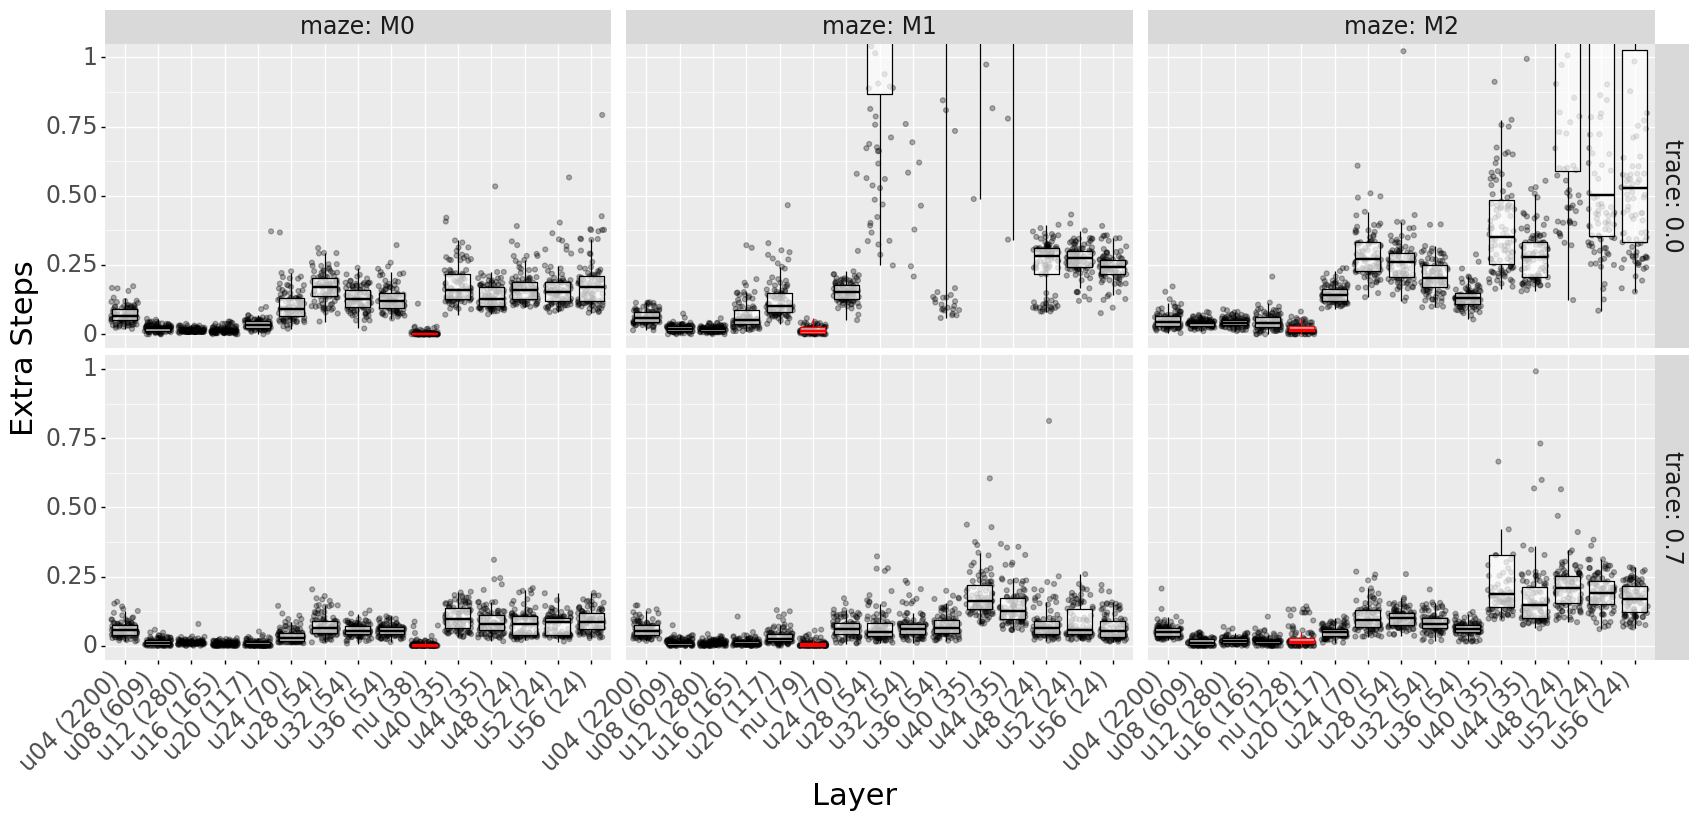

<ggplot: (118383548344)>

      PLOT: BOXPLOT - e4_Boxplot-learn_time-l1000-Th1MST


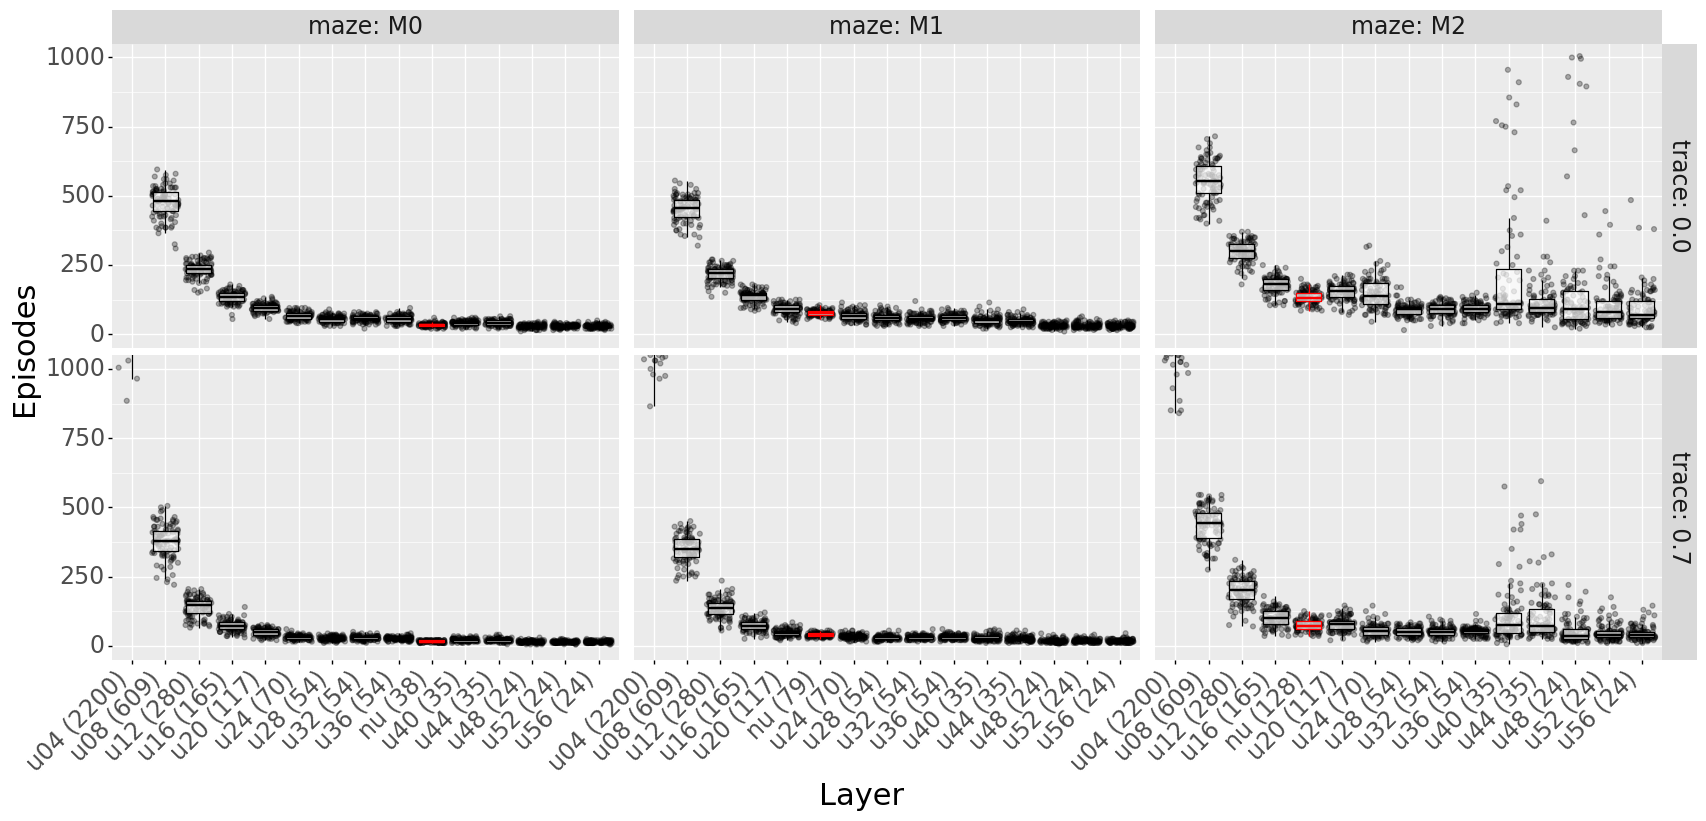

<ggplot: (118385703623)>

      PLOT: RUNTIME - e4_runtimes-M0-T7-y1-x10000MST


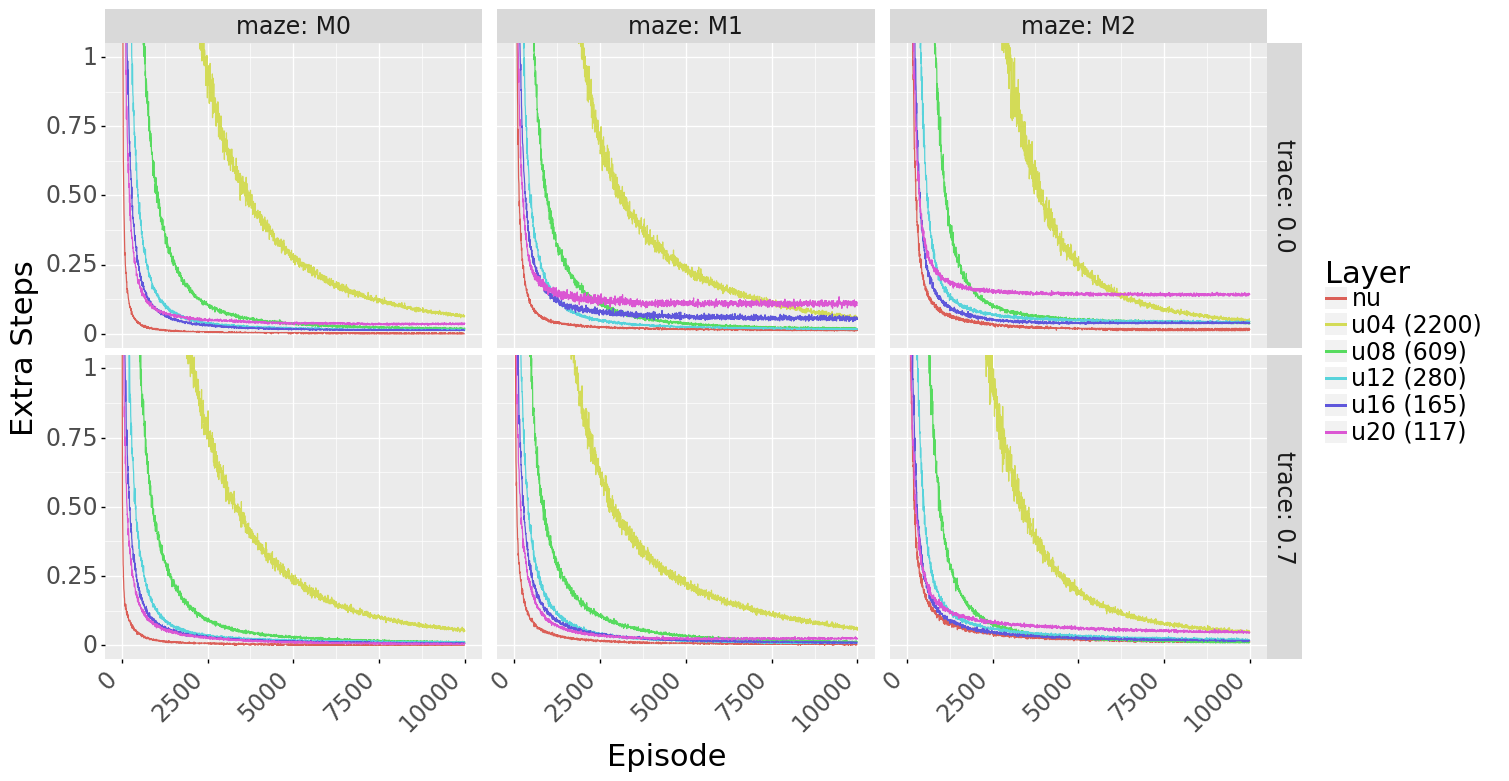

<ggplot: (118385669250)>

In [57]:
# BOXPLOT FUNCTION
reset_gg_defaults()

def plot_box_plot(data, x_column, y_column, x_title, y_title, plot_title, ylim, box_colors):
    # print(data)
    p0 = ggplot(data, aes(x_column, y_column ))
    p0 += facet_grid(f'trace ~ maze', scales='free_x', labeller='label_both')
    p0 += geom_jitter(alpha=0.3)
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0, color = box_colors )
    p0 += labs(x=x_title, y=y_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust = 1), figure_size = (20,8), panel_spacing_x=0.15)
    p0 += coord_cartesian(ylim=ylim)              
    return p0

def plot_time_series(data, x_column, y_column, fill_column, x_title, y_title, legend_title, plot_title, xlim, ylim):
    p0 = ggplot(data, aes(x_column, y_column, color=fill_column))
    p0 += facet_grid(f'trace ~ maze', scales='free_x', labeller='label_both')
    p0 += geom_line()
    p0 += labs(x=x_title, y=y_title, color=legend_title, title=plot_title, caption='smt')
    p0 += coord_cartesian(ylim=ylim, xlim=xlim)
    p0 += scale_color_discrete(na_translate = 'F', drop=True)
    return p0


# plt.close('all')

# PLOT EXTRA STEP RATIOS
maze_num = '2' if '8' in m else m[1:]
plot_title = f''
lims = [0, 1]

# in total there are 90 groups, we must set the color for each boxplot
# all are black except for the non uniform distributions
colors = ['black' for i in range(90)]
colors[9] = colors[20] = colors[34] = colors[54] = colors[65] = colors[79] = 'red'

save_name = f'e4_Boxplots-extra_steps-l{lims[1]}MST'
print(f'      PLOT: BOXPLOT - {save_name}')
plot = plot_box_plot(runtimes_last_episode, 'layer_alias1', 'steps', 'Layer', 'Extra Steps', plot_title, lims, colors)
plot += theme( )
display(plot)
ggsave(plot, folder_nu + save_name + '.pdf', dpi=300, verbose = False)
ggsave(plot, folder_nu + save_name + '.png', dpi=300, verbose = False)


# PLOT LEARNING TIMES TIME
plot_title = ''
lims = [0, 1000]
save_name = f'e4_Boxplot-learn_time-l{lims[1]}-Th{threshold}MST'
print(f'      PLOT: BOXPLOT - {save_name}')
plot = plot_box_plot(learning_times, 'layer_alias1', 'episode', 'Layer', 'Episodes', plot_title, lims, colors)
display(plot)
ggsave(plot, folder_nu + save_name + '.pdf', dpi=300, verbose = False)
ggsave(plot, folder_nu + save_name + '.png', dpi=300, verbose = False)




# PLOT EXTRA STEP RATIOS TIME SERIES
ylims = [0, 1]
xlims = [0, 10000]

save_name = f'e4_runtimes-{m}-T{int(t*10)}-y{ylims[1]}-x{xlims[1]}MST'
print(f'      PLOT: RUNTIME - {save_name}')
display_set = summaries
display_set = display_set[(display_set.num_cells > 80) | display_set.layer_alias2.apply(lambda n : n[0]=='n')].copy()
display_set.layer_alias2 = display_set.layer_alias2.cat.remove_unused_categories()

# display_set.layer_alias.astype()
plot = plot_time_series(display_set, 'episode', 'steps' , 'layer_alias2', 'Episode', 'Extra Steps', 'Layer', plot_title , xlims, ylims )
plot += theme( figure_size = (15,8) )
display(plot)
ggsave(plot, folder_nu + save_name + '.pdf', dpi=300, verbose = False)
ggsave(plot, folder_nu + save_name + '.png', dpi=300, verbose = False)


## Density Experiment - Learning time in first episode vs num obstacles

In [58]:
# CHOOSE PARAMETERS
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]

# CREATE FOLDERS FOR EXPERIMENT
folder_first_episode = os.path.join(figure_folder, 'density_first_episode/')
make_folder(folder_first_episode)


# GET RELEVANT CONFIGS
# keep mazes with varying number of obstacles only (all but M1 and M8), and get only layer 04 wutg traces 0
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0:3] == 'u04') & (configs.traces == 0)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10).astype('category')
experiment_configs['num_obstacles_num'] = experiment_configs.maze.map(lambda m : int(m[1])*10)


# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'num_obstacles_num']
episode = 0
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location, skip_summary=True)

from scipy.stats import kruskal, f_oneway
from scikit_posthocs import posthoc_dunn as dunn_test, posthoc_tukey as tukey

k = f_oneway(*[group["steps"].values for name, group in runtimes_last_episode.groupby("num_obstacles")])
dunn = dunn_test(runtimes_last_episode, val_col='steps', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
dunn2 = dunn_test(runtimes_last_episode, val_col='steps', group_col='num_obstacles', p_adjust=None, sort = False)
tuk = tukey(runtimes_last_episode, val_col='steps', group_col='num_obstacles_num', sort = False)


# tuk = tukey(endog=runtimes_last_episode['steps'], groups=runtimes_last_episode['num_obstacles'])
# display(f'stat: {k}')


display(tuk,dunn, dunn2)

# DISPLAY
# display(experiment_configs)
# display(runtimes_last_episode)


0    10   20   30   40   50   60
0  1.00 0.84 0.88 0.00 0.48 0.00 0.00
10 0.84 1.00 0.90 0.07 0.90 0.01 0.00
20 0.88 0.90 1.00 0.06 0.90 0.01 0.00
30 0.00 0.07 0.06 1.00 0.30 0.90 0.61
40 0.48 0.90 0.90 0.30 1.00 0.06 0.00
50 0.00 0.01 0.01 0.90 0.06 1.00 0.90
60 0.00 0.00 0.00 0.61 0.00 0.90 1.00

0   10   20   30   40   50   60
0  1.00 1.00 1.00 0.01 0.86 0.00 0.00
10 1.00 1.00 1.00 0.15 1.00 0.06 0.01
20 1.00 1.00 1.00 0.21 1.00 0.08 0.01
30 0.01 0.15 0.21 1.00 1.00 1.00 1.00
40 0.86 1.00 1.00 1.00 1.00 1.00 0.37
50 0.00 0.06 0.08 1.00 1.00 1.00 1.00
60 0.00 0.01 0.01 1.00 0.37 1.00 1.00

0   10   20   30   40   50   60
0  1.00 0.40 0.35 0.00 0.04 0.00 0.00
10 0.40 1.00 0.92 0.01 0.23 0.00 0.00
20 0.35 0.92 1.00 0.01 0.27 0.00 0.00
30 0.00 0.01 0.01 1.00 0.14 0.77 0.37
40 0.04 0.23 0.27 0.14 1.00 0.08 0.02
50 0.00 0.00 0.00 0.77 0.08 1.00 0.55
60 0.00 0.00 0.00 0.37 0.02 0.55 1.00

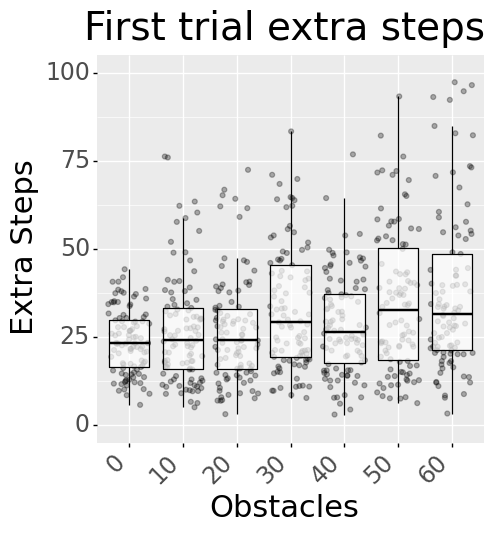

<ggplot: (118385649939)>

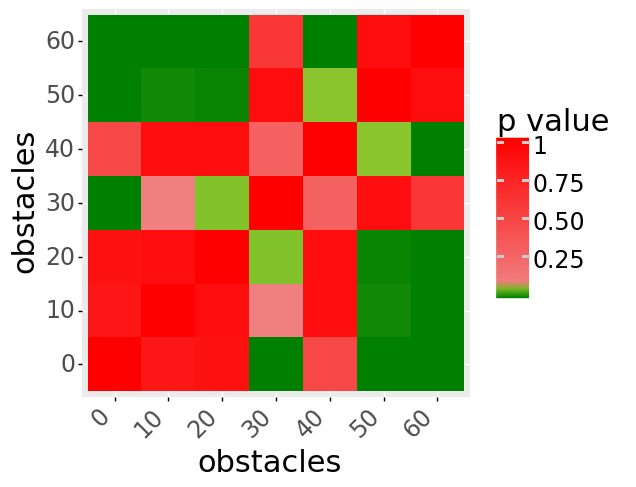

<ggplot: (118389949468)>

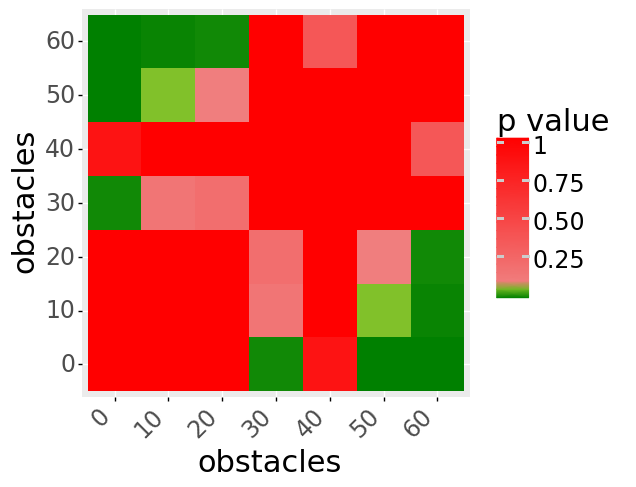

<ggplot: (118383222872)>

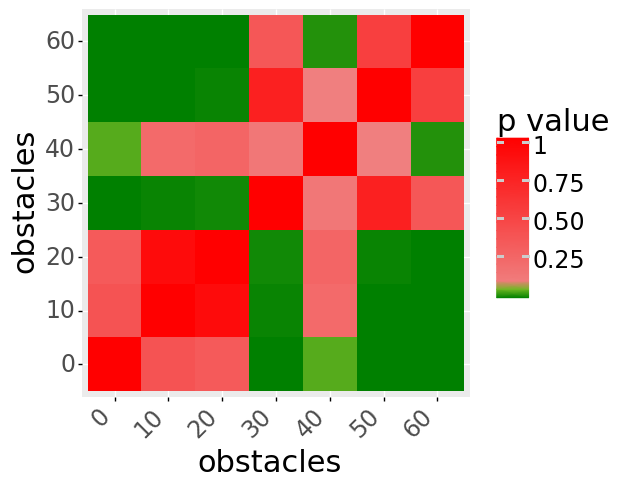

<ggplot: (118385536699)>

In [59]:
def plot_box_plot(data, x_column, y_column, x_title, y_title, plot_title, ylim, box_colors):
    # print(data)
    p0 = ggplot(data, aes(x_column, y_column ))
    p0 += geom_jitter(alpha=0.3)
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0, color = box_colors )
    p0 += labs(x=x_title, y=y_title, title=plot_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=1))
    p0 += coord_cartesian(ylim=ylim)   
    p0 += theme(
        aspect_ratio=1,
        figure_size=(5, 5)
    )
    return p0


lims = [0, 100]
p = plot_box_plot(runtimes_last_episode, 'num_obstacles', 'steps', 'Obstacles', 'Extra Steps', "First trial extra steps", lims, 'black')
ggsave(p, folder_first_episode + 'e1_first_episodeMST.pdf', dpi=300, verbose = False)
ggsave(p, folder_first_episode + 'e1_first_episodeMST.png', dpi=300, verbose = False)
display(p)


p = plot_pairwise_posthoc_test(tuk, 0.07)
p += labs(x='obstacles', y='obstacles')
ggsave(p, folder_first_episode + 'e1_first_episode_tukey.pdf', dpi=300, verbose = False)
ggsave(p, folder_first_episode + 'e1_first_episode_tukey.png', dpi=300, verbose = False)
display(p)


p = plot_pairwise_posthoc_test(dunn, 0.07)
p += labs(x='obstacles', y='obstacles')
ggsave(p, folder_first_episode + 'e1_first_episode_dunn_bonferroni.pdf', dpi=300, verbose = False)
ggsave(p, folder_first_episode + 'e1_first_episode_dunn_bonferroni.png', dpi=300, verbose = False)
display(p)



p = plot_pairwise_posthoc_test(dunn2, 0.07)
p += labs(x='obstacles', y='obstacles')
ggsave(p, folder_first_episode + 'e1_first_episode_dunn_no_corrections.pdf', dpi=300, verbose = False)
ggsave(p, folder_first_episode + 'e1_first_episode_dunn_no_corrections.png', dpi=300, verbose = False)
display(p)


## Density experiment - fixed number of obstacles

In [6]:
# CHOOSE PARAMETERS
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]
num_obstacles = [i*10 for i in range(7)]
layers = [f'u{4*i:02d}' for i in range(1,15)]
traces = [0, 0.7]

o = num_obstacles[0]
t = traces[0]
l = layers[1]

# CREATE FOLDERS FOR EXPERIMENT
folder_density_obstacle_num = os.path.join(figure_folder, 'density_fixed_obstacle_num/')
make_folder(folder_density_obstacle_num)


# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0] == 'u') & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')
experiment_configs = experiment_configs[(experiment_configs.num_obstacles == o) & (experiment_configs.scale % 8 == 0)]


# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'scale', 'number of cells']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells']
# display(experiment_configs['number of cells'].unique())
display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(learning_times)



c_id maze  num_obstacles     pcs  scale  number of cells
config                                                          
c2         2   M0              0  u08_21      8              609
c4         4   M0              0  u08_25      8              875
c6         6   M0              0  u08_30      8             1230
c8         8   M0              0  u08_35      8             1680
c10       10   M0              0  u08_40      8             2200
c26       26   M0              0  u16_11     16              165
c28       28   M0              0  u16_15     16              315
c30       30   M0              0  u16_20     16              560
c32       32   M0              0  u16_25     16              875
c34       34   M0              0  u16_30     16             1230
c36       36   M0              0  u16_35     16             1680
c38       38   M0              0  u16_40     16             2200
c56       56   M0              0  u24_07     24               70
c58       58   M0              0  u24_10     24              140
c60       60   M0              0  u24_15     24              315
c62       62   M0              0  u24_20     24              560
c64       64   M0              0  u24_25     24              875
c66       66   M0              0  u24_30     24             1230
c68       68   M0              0  u24_35     24             1680
c70       70   M0              0  u24_40     24             2200
c88       88   M0              0  u32_06     32               54
c90       90   M0              0  u32_10     32              140
c92       92   M0              0  u32_15     32              315
c94       94   M0              0  u32_20     32              560
c96       96   M0              0  u32_25     32              875
c98       98   M0              0  u32_30     32             1230
c100     100   M0              0  u32_35     32             1680
c102     102   M0              0  u32_40     32             2200
c120     120   M0              0  u40_05     40               35
c122     122   M0              0  u40_10     40              140
c124     124   M0              0  u40_15     40              315
c126     126   M0              0  u40_20     40              560
c128     128   M0              0  u40_25     40              875
c130     130   M0              0  u40_30     40             1230
c132     132   M0              0  u40_35     40             1680
c134     134   M0              0  u40_40     40             2200
c152     152   M0              0  u48_04     48               24
c154     154   M0              0  u48_05     48               35
c156     156   M0              0  u48_10     48              140
c158     158   M0              0  u48_15     48              315
c160     160   M0              0  u48_20     48              560
c162     162   M0              0  u48_25     48              875
c164     164   M0              0  u48_30     48             1230
c166     166   M0              0  u48_35     48             1680
c168     168   M0              0  u48_40     48             2200
c188     188   M0              0  u56_04     56               24
c190     190   M0              0  u56_05     56               35
c192     192   M0              0  u56_10     56              140
c194     194   M0              0  u56_15     56              315
c196     196   M0              0  u56_20     56              560
c198     198   M0              0  u56_25     56              875
c200     200   M0              0  u56_30     56             1230
c202     202   M0              0  u56_35     56             1680
c204     204   M0              0  u56_40     56             2200

config  location  rat  episode     steps  c_id  num_obstacles  scale  \
0          2       255    0      390  0.976939     2              0      8   
1          2       255    1      445  0.934271     2              0      8   
2          2       255    2      440  0.982514     2              0      8   
3          2       255    3      485  0.881655     2              0      8   
4          2       255    4      455  0.941172     2              0      8   
...      ...       ...  ...      ...       ...   ...            ...    ...   
5395     204       255   95     1615  0.988743   204              0     56   
5396     204       255   96     2190  0.994204   204              0     56   
5397     204       255   97     2125  0.850401   204              0     56   
5398     204       255   98     2100  0.992019   204              0     56   
5399     204       255   99     2260  0.963950   204              0     56   

      number of cells  
0                 609  
1                 609  
2                 609  
3                 609  
4                 609  
...               ...  
5395             2200  
5396             2200  
5397             2200  
5398             2200  
5399             2200  

[5400 rows x 9 columns]

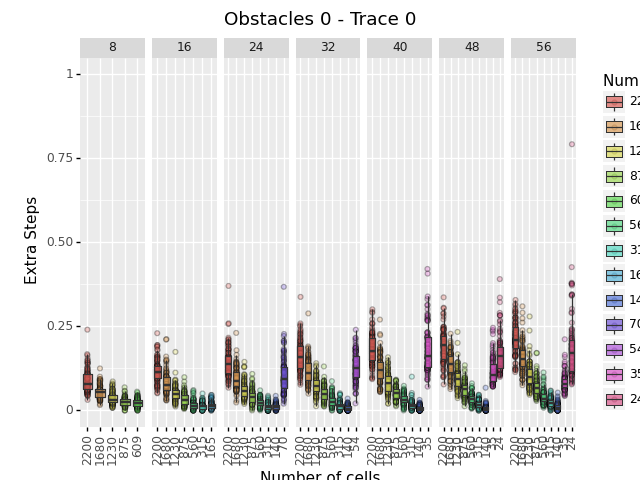

<ggplot: (146195772194)>

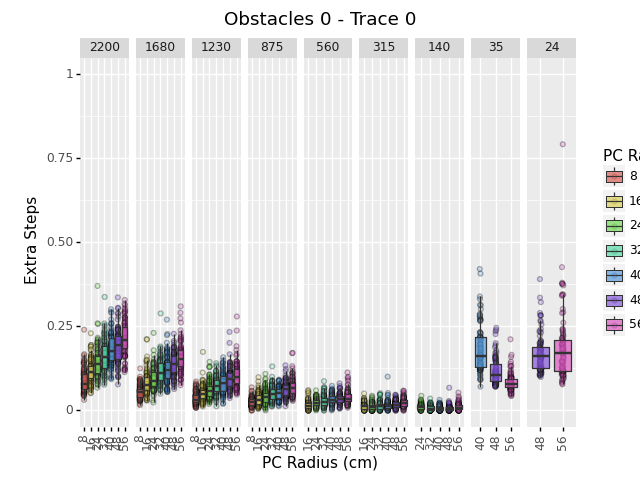

<ggplot: (146172450012)>

In [ ]:
folder_density_obstacle_num = os.path.join(figure_folder, 'density_fixed_obstacle_num/test/')
make_folder(folder_density_obstacle_num)

# BOXPLOT FUNCTION
def plot_faceted_box_plot(data, x_column, y_column, facet_column, x_title, y_title, plot_title, lims):
    p0 = ggplot(data, aes(x_column, y_column, fill=x_column ))
    p0 += facet_grid(f'. ~ {facet_column}', scales='free')
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=x_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

# plt.close('all')

# PLOT BOXPLOTS SCALE
plot_title = f'Obstacles {o} - Trace {t}'
lims = [0, 1]
save_name = f'Boxplots_Scale-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

r2 = runtimes_last_episode[runtimes_last_episode.scale > 4].copy()
r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
r2['scale_d'] = pd.Categorical(r2['scale'], np.sort(r2['scale'].unique())) 
box_plot_scale = plot_faceted_box_plot(r2, 'num_cells', 'steps', 'scale_d', 'Number of cells', 'Extra Steps' , plot_title, lims)
# ggsave(box_plot_scale, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME SCALE
lims = [0, 5000]
save_name = f'Learn_time_Scale-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

learn_times_2 = learning_times[learning_times.scale > 4].copy()
learn_times_2['num_cells'] = pd.Categorical(learn_times_2['number of cells'], np.sort(learn_times_2['number of cells'].unique())[::-1])
learn_times_2['scale_d'] = pd.Categorical(learn_times_2['scale'], np.sort(learn_times_2['scale'].unique())) 

learn_time_plot_scale = plot_faceted_box_plot(learn_times_2, 'num_cells', 'episode', 'scale_d', 'Number of Cells', 'Episodes' , plot_title, lims)      
# ggsave(learn_time_plot_scale, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT BOXPLOT CELLS
lims = [0, 1]
save_name = f'Boxplots_Cells-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = runtimes_last_episode['number of cells'].value_counts()
filtered_runtimes = runtimes_last_episode[runtimes_last_episode['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_runtimes['num_cells'] = pd.Categorical(filtered_runtimes['number of cells'], np.sort(filtered_runtimes['number of cells'].unique())[::-1])
filtered_runtimes['scale_d'] = pd.Categorical(filtered_runtimes['scale'], np.sort(filtered_runtimes['scale'].unique())) 

box_plot_cells = plot_faceted_box_plot(filtered_runtimes, 'scale_d', 'steps', 'num_cells', 'PC Radius (cm)', 'Extra Steps' , plot_title, lims)
# ggsave(box_plot_cells, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME CELLS
lims = [0, 5000]
save_name = f'Learn_Time_Cells-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = learning_times['number of cells'].value_counts()
filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_learn_times['num_cells'] = pd.Categorical(filtered_learn_times['number of cells'], np.sort(filtered_learn_times['number of cells'].unique())[::-1])
filtered_learn_times['scale_d'] = pd.Categorical(filtered_learn_times['scale'], np.sort(filtered_learn_times['scale'].unique())) 

learn_time_plot_cells = plot_faceted_box_plot(filtered_learn_times, 'scale_d', 'episode', 'num_cells', 'PC Radius (cm)', 'Episodes', plot_title, lims)
# ggsave(learn_time_plot_cells, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)

display(box_plot_scale)
# display(learn_time_plot_scale)
display(box_plot_cells)
# display(learn_time_plot_cells)


## Density experiment - density

Non-uniform        simple_name  number of cells  coverage
21           non_uniform_0.csv               38  1.700507
22           non_uniform_1.csv               79  1.582712
23           non_uniform_8.csv              128  1.551667

Multiscale uniform     simple_name  number of cells  coverage
20                  ml_4_16_52.csv             2389  5.240555

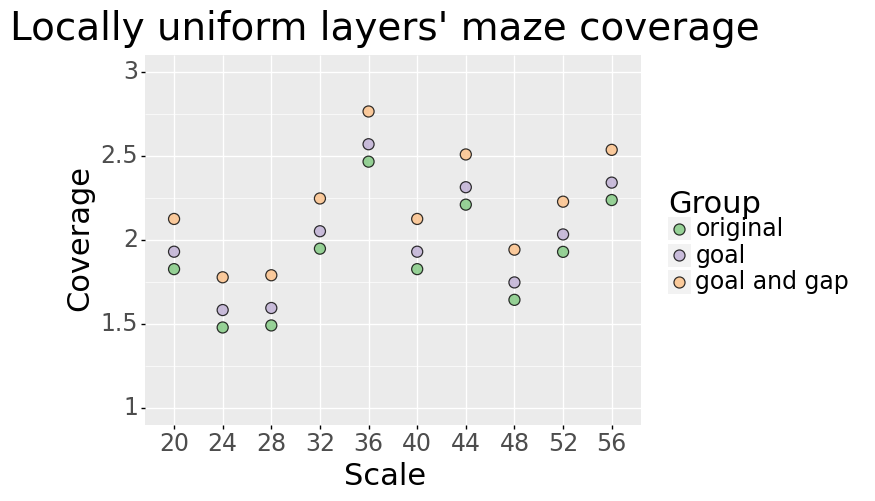

<ggplot: (115958496603)>

In [7]:
# PLOT LAYER DENSITIES
metric = 'coverage'

# GET LAYER METRICS OF EACH LAYER TYPE
uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'u') ].copy()
locally_uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'l' or (v[0:-4] in min_layers[4:14]))].copy()
non_uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'n') ].copy()
multiscale_uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'm') ].copy()

                                                                             
# PREPARING UNIFOR METRIC FIELDS
uniform_layer_metrics['scale'] = uniform_layer_metrics.simple_name.map(lambda v : int(v[1:3]))
locally_uniform_layer_metrics['scale'] = locally_uniform_layer_metrics.simple_name.map(lambda v : int(v[4:6]) if v[0]=='l' else int(v[1:3]))
categories =  CategoricalDtype(['original', 'goal', 'goal and gap'] , ordered=True)
locally_uniform_layer_metrics['group'] = locally_uniform_layer_metrics.simple_name.map(lambda l : 'original' if l[0]=='u' else 'goal' if l[2] == '0' else 'goal and gap').astype(categories)



# DISPLAY DATA
uniform_layer_metrics.columns.name = "Uniform"
non_uniform_layer_metrics.columns.name = "Non-uniform"
locally_uniform_layer_metrics.columns.name = "Locally uniform"
multiscale_uniform_layer_metrics.columns.name = "Multiscale uniform"
# display(uniform_layer_metrics)
# display(locally_uniform_layer_metrics)
display(non_uniform_layer_metrics[['simple_name','number of cells', 'coverage']])
display(multiscale_uniform_layer_metrics[['simple_name','number of cells', 'coverage']])

# PLOT UNIFORM
p0 = ggplot(uniform_layer_metrics, aes('factor(scale)', 'coverage', fill = 'factor(num_cells)' ))
p0 += geom_point(size=4, alpha=0.5)
p0 += labs(x='Scale', y='Coverage', fill='Cells', title='Uniform layers\' maze coverage') # fill = x_title
p0 += coord_cartesian(ylim=[1,300])

ggsave(p0, figure_folder + 'coverage_per_layer.pdf', dpi=300, verbose = False, width = 6, height =5)

# PLOT LOCALLY UNIFORM
p1 = ggplot(locally_uniform_layer_metrics, aes('factor(scale)', 'coverage', fill = 'group' ))
p1 += geom_point(size=4, alpha=0.8)
p1 += labs(x='Scale', y='Coverage', fill='Group', title='Locally uniform layers\' maze coverage') # fill = x_title
p1 += scale_fill_brewer(type="qual", palette=1)
p1 += coord_cartesian(ylim=[1,3])

ggsave(p1, figure_folder + 'coverage_per_layer_locally_uniform.pdf', dpi=300, verbose = False, width = 6, height =5)


# DISPLAY PLOTS:
# display(p0)
display(p1)




In [8]:
# CHOOSE PARAMETERS
density_metrics = ['normalized mean distance density', 'coverage', 'normalized coverage']
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]
num_obstacles = [i*10 for i in range(7)]

traces = [0, 0.7]

o = num_obstacles[6]
t = traces[0]
multiples_of = 8

# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0] == 'u') & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')

# create metric: coverage per cell
density_metrics += ['coverage per cell']
experiment_configs['coverage per cell'] = experiment_configs['coverage'] / experiment_configs['number of cells']

display(experiment_configs.columns)



Index(['experiment', 'group', 'mazeFile', 'numStartingPositions', 'pc_files',
       'traces', 'numEpisodes', 'c_id', 'pcs', 'maze', 'num_obstacles',
       'scale', 'layer', 'number of cells', 'total area', 'mean area',
       'mean radius', 'mean distance', 'normalized mean distance', 'coverage',
       'simple_name', 'normalized mean distance density',
       'normalized coverage', 'num_cells', 'coverage per cell'],
      dtype='object')

c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 5 x 5 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/density_density/redundancyMST.pdf
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 5 x 5 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/density_density/redundancyMST.png


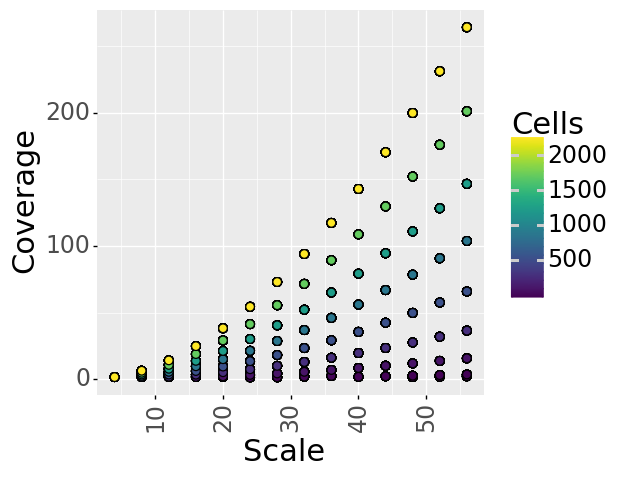

<ggplot: (115832393954)>

In [9]:

# function to plot densities:
def plot_all_densities(data, x_column, y_column, fill_column, x_title, y_title, plot_title, lims = None):
    p0 = ggplot(data, aes(x_column, y_column, fill = fill_column))
    p0 += geom_point(size=3)
    p0 += labs(x=x_title, y=y_title, title=plot_title) # fill = x_title
    # p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    if lims is not None:
        p0 += coord_cartesian(ylim=lims)  #+ coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

# CREATE FOLDERS FOR EXPERIMENT
folder_density_density = os.path.join(figure_folder, 'density_density/')
make_folder(folder_density_density)


density_scatter = plot_all_densities(experiment_configs, 'scale', 'coverage', 'number of cells', 'Scale', metric, 'Cells')
density_scatter += labs(x = 'Scale', y='Coverage',title='', fill='Cells')
density_scatter += theme(
    figure_size = (5,5)
)
ggsave(density_scatter, folder_density_density + 'redundancyMST.pdf', dpi=300)
ggsave(density_scatter, folder_density_density + 'redundancyMST.png', dpi=300)
display(density_scatter)

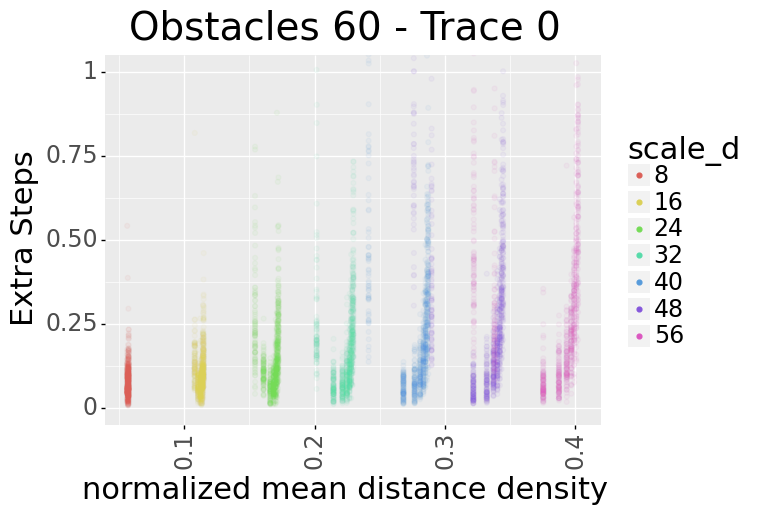

<ggplot: (115832790727)>

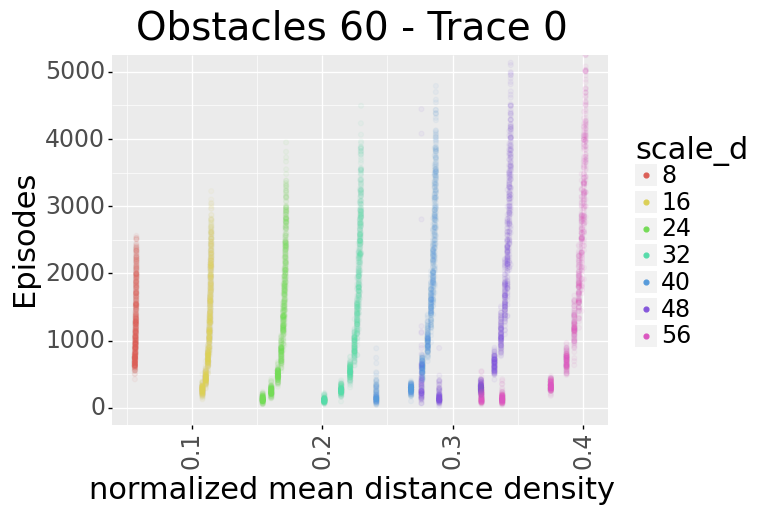

<ggplot: (115832470619)>

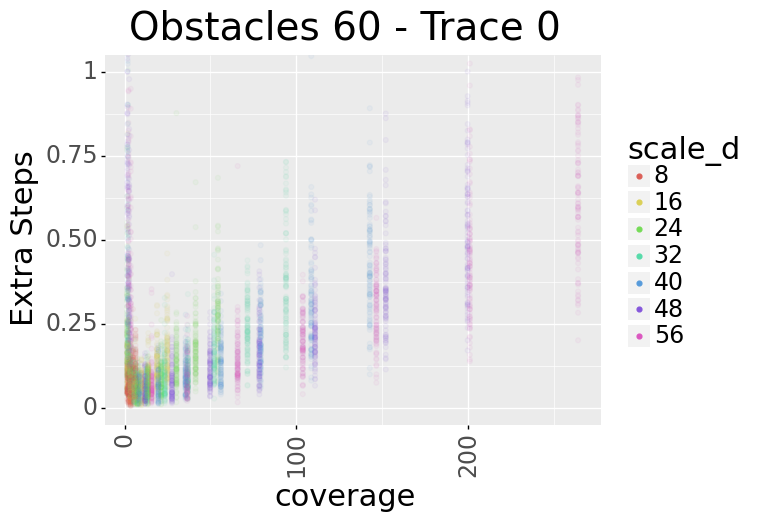

<ggplot: (115832346429)>

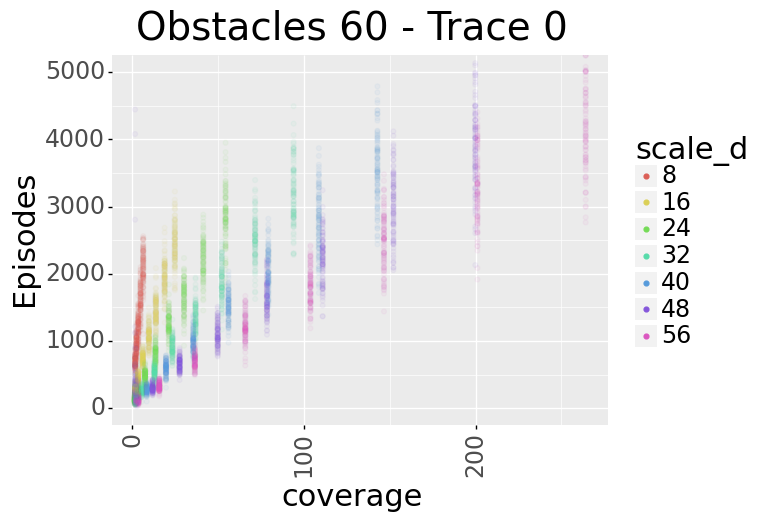

<ggplot: (115833344537)>

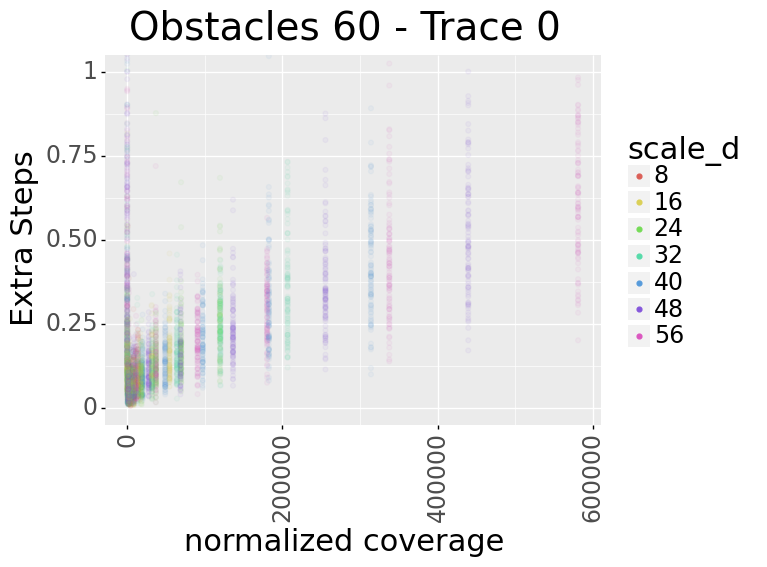

<ggplot: (115832882685)>

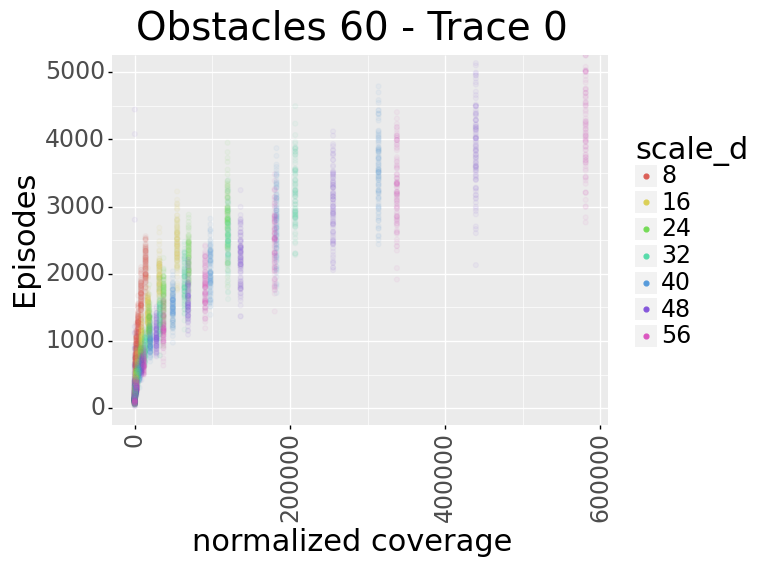

<ggplot: (115830191797)>

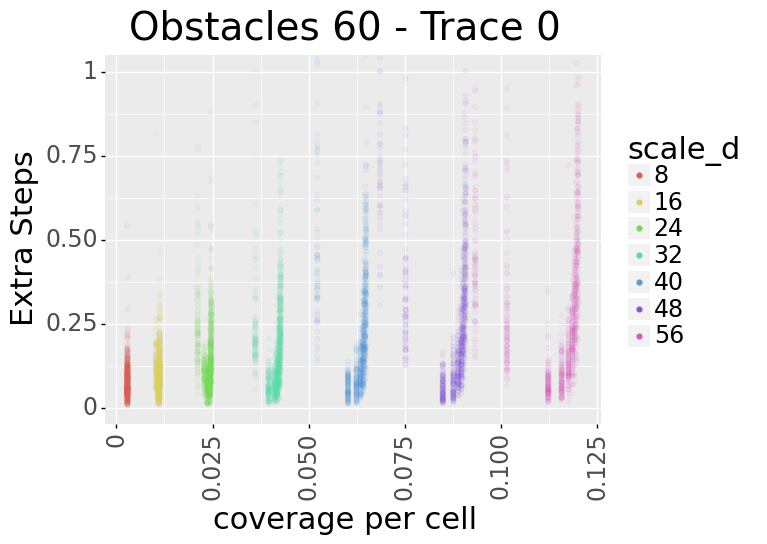

<ggplot: (115832622978)>

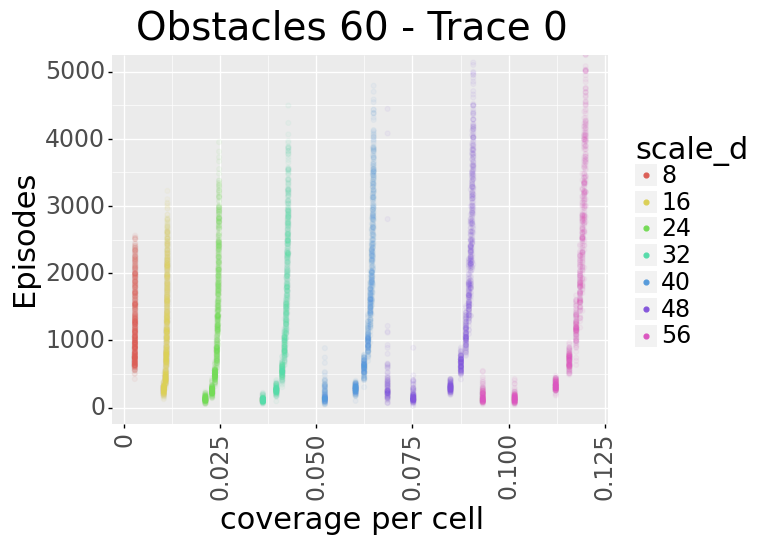

<ggplot: (115832664899)>

In [11]:
experiment_configs = experiment_configs[(experiment_configs.num_obstacles == o) & (experiment_configs.scale % multiples_of == 0)]

# experiment_configs = experiment_configs[(experiment_configs.num_obstacles == o) & (experiment_configs.scale / 12 <= 1)]

# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'scale', 'number of cells'] + density_metrics
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells'] + density_metrics
# # display(experiment_configs['number of cells'].unique())
# display(experiment_configs[fields])
# # display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
# display(learning_times)




# BOXPLOT FUNCTION
def plot_density_scatter(data, x_column, y_column, fill_column, x_title, y_title, plot_title, lims = None):
    p0 = ggplot(data, aes(x_column, y_column, color=fill_column))
    # p0 += geom_point(alpha=0.2)
    p0 += geom_jitter(alpha=0.05)
    p0 += labs(x=x_title, y=y_title, title=plot_title) # fill = x_title
    # p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    if lims is not None:
        p0 += coord_cartesian(ylim=lims)  #+ coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    p0 += guides(color = guide_legend(override_aes = {'alpha' : 1} ) )
    return p0
# plt.close('all')

# PLOT
for metric in density_metrics:
    plot_title = f'Obstacles {o} - Trace {t}'
    lims = [0, 1]
    save_name = f'Scatter-Steps-O{o}-T{int(t*10)}-l{lims[1]}-{metric}.pdf'
    # print(f'      PLOT: {save_name}')

    r2 = runtimes_last_episode.copy()
    r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
    r2['scale_d'] = pd.Categorical(r2['scale'], np.sort(r2['scale'].unique())) 
    scatter_steps = plot_density_scatter(r2, metric, 'steps', 'scale_d', metric, 'Extra Steps' , plot_title, lims)
    ggsave(scatter_steps, folder_density_density + save_name, dpi=300, verbose = False, width = 10, height =5)


    # PLOT LEARN TIME SCALE
    lims = [0, 5000]
    save_name = f'Scatter-Learn_time-O{o}-T{int(t*10)}-l{lims[1]}-{metric}.pdf'
    # print(f'      PLOT: {save_name}')

    learn_times_2 = learning_times.copy()
    learn_times_2['num_cells'] = pd.Categorical(learn_times_2['number of cells'], np.sort(learn_times_2['number of cells'].unique())[::-1])
    learn_times_2['scale_d'] = pd.Categorical(learn_times_2['scale'], np.sort(learn_times_2['scale'].unique())) 

    scatter_learn_time = plot_density_scatter(learn_times_2, metric, 'episode', 'scale_d', metric, 'Episodes' , plot_title, lims)
    ggsave(scatter_learn_time, folder_density_density + save_name, dpi=300, verbose = False, width = 10, height =5)


    display(scatter_steps)
    display(scatter_learn_time)


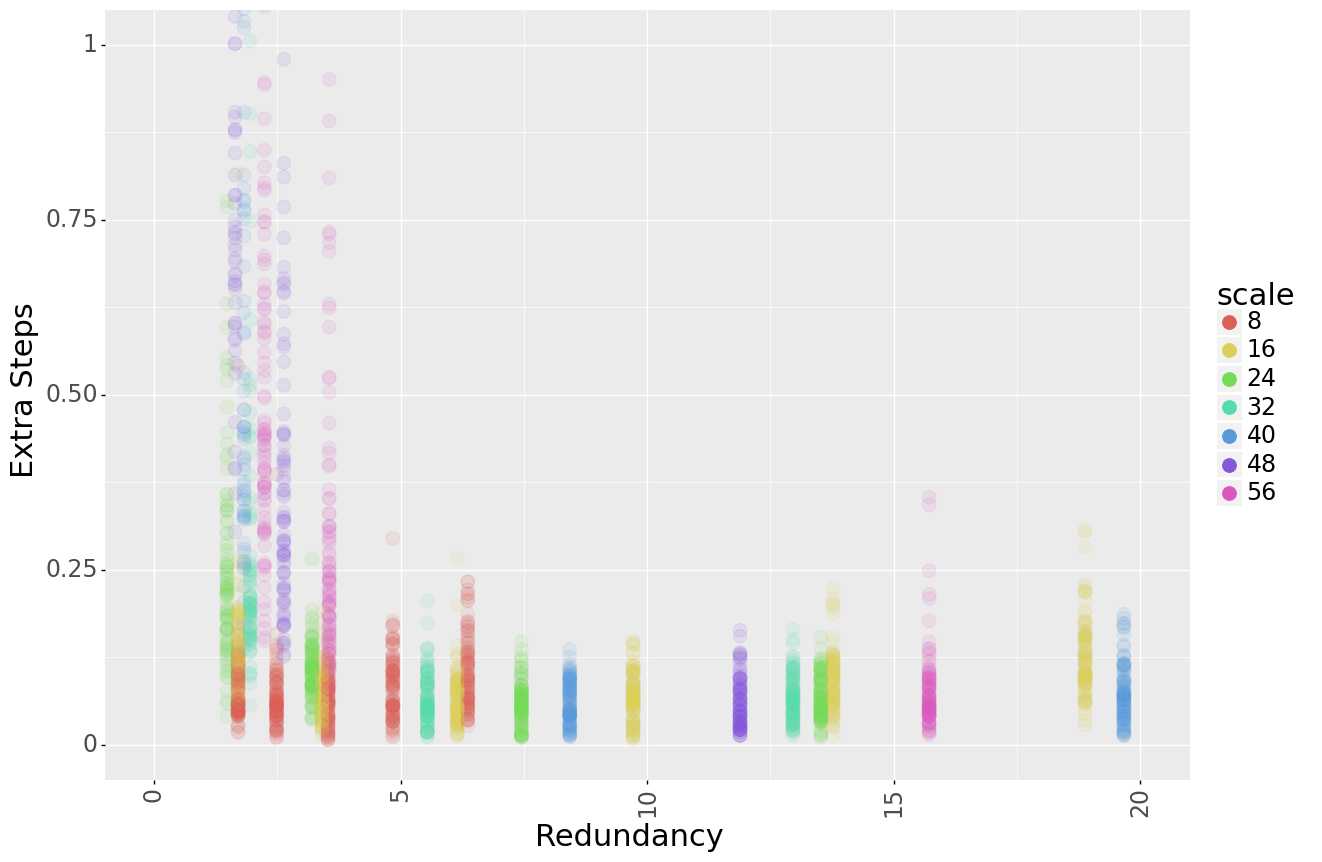

<ggplot: (115958500789)>

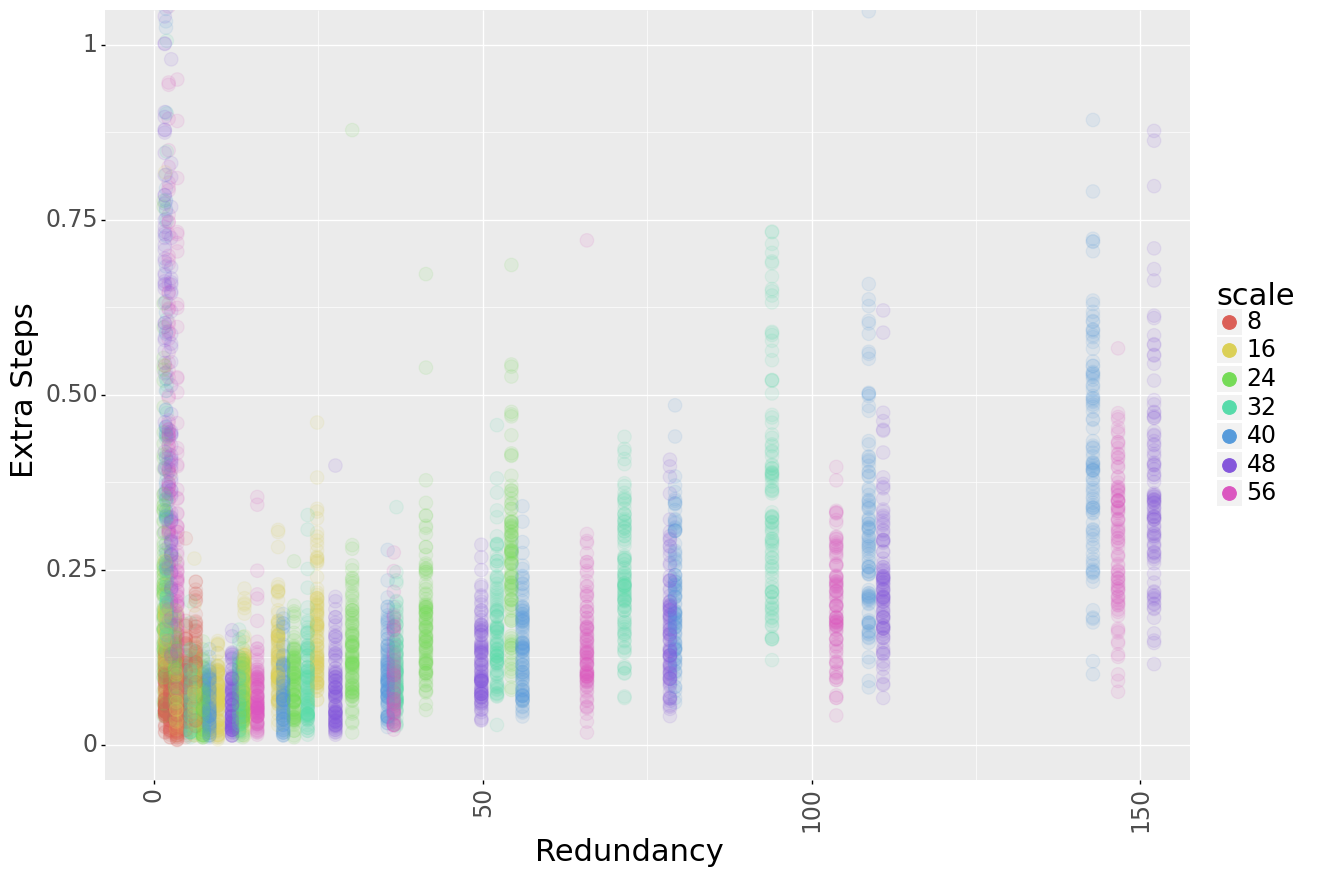

<ggplot: (115958500789)>

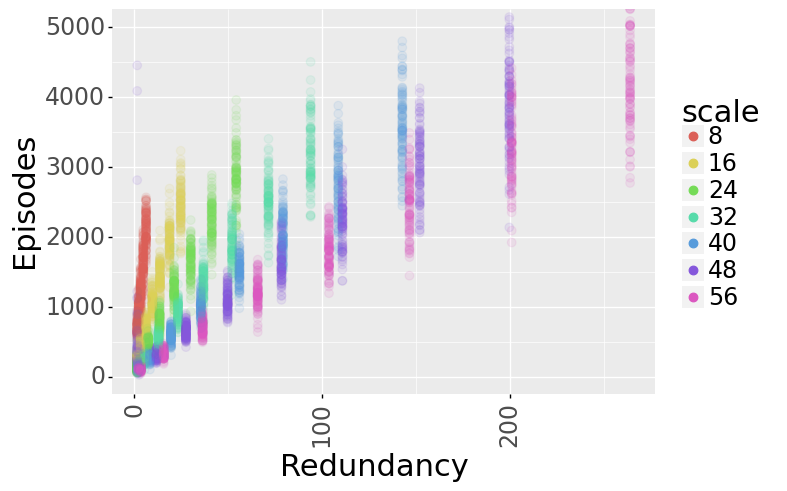

<ggplot: (115832504911)>

In [30]:
# PLOT LEARNING TIME AND EXTRA STEP RATIOS VS REDUNDANCY
reset_gg_defaults()


def plot_density_scatter(data, x_column, y_column, fill_column, x_title, y_title, plot_title, lims = None, dot_size=3):
    p0 = ggplot(data, aes(x_column, y_column, color=fill_column))
    p0 += geom_jitter(alpha=0.1, size=dot_size)
    p0 += labs(x=x_title, y=y_title, title=plot_title) # fill = x_title
    # p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    if lims is not None:
        p0 += coord_cartesian(ylim=lims)  #+ coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    p0 += guides(color = guide_legend(override_aes = {'alpha' : 1} ) )
    return p0


plot_title = f''
lims = [0, 1]
save_name = f'e1_extra_steps_vs_redundancyMST.pdf'

r2 = runtimes_last_episode.copy()
# r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
r2['scale'] = pd.Categorical(r2['scale'], np.sort(r2['scale'].unique())) 
plot = plot_density_scatter(r2, 'coverage', 'steps', 'scale', metric, 'Extra Steps' , plot_title, lims, dot_size=5)
plot += theme( figure_size = (14,10)  )
plot += labs(x='Redundancy')
plot += coord_cartesian(ylim=[0,1], xlim=[0,20])
display(plot)
ggsave(plot, folder_density_density + save_name, dpi=300, verbose = False)

plot += coord_cartesian(ylim=[0,1], xlim=[0,150])
display(plot)
# ggsave(plot, folder_density_density + save_name, dpi=300, verbose = False)


# PLOT LEARN TIME SCALE
lims = [0, 5000]
save_name = f'e1_learning_time_vs_redundancyMST.pdf'
learn_times_2 = learning_times.copy()
# learn_times_2['num_cells'] = pd.Categorical(learn_times_2['number of cells'], np.sort(learn_times_2['number of cells'].unique())[::-1])
learn_times_2['scale'] = pd.Categorical(learn_times_2['scale'], np.sort(learn_times_2['scale'].unique())) 
plot = plot_density_scatter(learn_times_2, 'coverage', 'episode', 'scale', metric, 'Episodes' , plot_title, lims)
plot += theme( figure_size = (7,5)  )
plot += labs(x='Redundancy')
display(plot)
ggsave(plot, folder_density_density + save_name, dpi=300, verbose = False)


## Density experiment - fixed scale

In [32]:
# CHOOSE PARAMETERS
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]
num_obstacles = [i*10 for i in range(7)]
layers = [f'u{8*i:02d}' for i in range(1,8)]
traces = [0, 0.7]

t = traces[0]
l = layers[6]

# CREATE FOLDERS FOR EXPERIMENT
folder_density_fixed_scale = os.path.join(figure_folder, 'density_fixed_scale/')
make_folder(folder_density_fixed_scale)


# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0:3] == l) & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')


# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'scale', 'number of cells']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells']
# display(experiment_configs['number of cells'].unique())
# display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
# display(learning_times)


In [33]:
# BOXPLOT FUNCTION
def plot_faceted_box_plot(data, x_column, y_column, facet_column, x_title, y_title, plot_title, lims):
    p0 = ggplot(data, aes(x_column, y_column, fill=x_column ))
    p0 += facet_grid(f'. ~ {facet_column}', scales='free')
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=x_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

# plt.close('all')

# PLOT BOXPLOTS SCALE
plot_title = f'Scale {l} - Trace {t}'
lims = [0, 1.5]
save_name = f'Boxplots_Obstacles-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

r2 = runtimes_last_episode.copy()
r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
r2['num_obstacles_d'] = pd.Categorical(r2['num_obstacles'], np.sort(r2['num_obstacles'].unique())) 
box_plot_scale = plot_faceted_box_plot(r2, 'num_cells', 'steps', 'num_obstacles_d', 'Number of cells', 'Extra Steps' , plot_title, lims)
ggsave(box_plot_scale, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME SCALE
lims = [0, 5000]
save_name = f'Learn_time_Obstacles-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

learn_times_2 = learning_times[learning_times.scale > 4].copy()
learn_times_2['num_cells'] = pd.Categorical(learn_times_2['number of cells'], np.sort(learn_times_2['number of cells'].unique())[::-1])
learn_times_2['num_obstacles_d'] = pd.Categorical(learn_times_2['num_obstacles'], np.sort(learn_times_2['num_obstacles'].unique())) 

learn_time_plot_scale = plot_faceted_box_plot(learn_times_2, 'num_cells', 'episode', 'num_obstacles_d', 'Number of Cells', 'Episodes' , plot_title, lims)      
ggsave(learn_time_plot_scale, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT BOXPLOT CELLS
lims = [0, 1.5]
save_name = f'Boxplots_Cells-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = runtimes_last_episode['number of cells'].value_counts()
filtered_runtimes = runtimes_last_episode[runtimes_last_episode['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_runtimes['num_cells'] = pd.Categorical(filtered_runtimes['number of cells'], np.sort(filtered_runtimes['number of cells'].unique())[::-1])
filtered_runtimes['num_obstacles_d'] = pd.Categorical(filtered_runtimes['num_obstacles'], np.sort(filtered_runtimes['num_obstacles'].unique())) 

box_plot_cells = plot_faceted_box_plot(filtered_runtimes, 'num_obstacles_d', 'steps', 'num_cells', 'Obstacles', 'Extra Steps' , plot_title, lims)
ggsave(box_plot_cells, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME CELLS
lims = [0, 5000]
save_name = f'Learn_Time_Cells-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = learning_times['number of cells'].value_counts()
filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_learn_times['num_cells'] = pd.Categorical(filtered_learn_times['number of cells'], np.sort(filtered_learn_times['number of cells'].unique())[::-1])
filtered_learn_times['num_obstacles_d'] = pd.Categorical(filtered_learn_times['num_obstacles'], np.sort(filtered_learn_times['num_obstacles'].unique())) 

learn_time_plot_cells = plot_faceted_box_plot(filtered_learn_times, 'num_obstacles_d', 'episode', 'num_cells', 'Obstacles', 'Episodes', plot_title, lims)
ggsave(learn_time_plot_cells, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)

display(box_plot_scale)
display(learn_time_plot_scale)
display(box_plot_cells)
display(learn_time_plot_cells)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135862072790)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135862691898)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135863374074)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135864467438)>

## Density experiment - best density for each number of obstacles / scale

In [26]:
# CREATE FOLDERS FOR EXPERIMENT
t=0
folder_density_best_densities = os.path.join(figure_folder, 'density_best_densities/')
make_folder(folder_density_best_densities)

# mazes for this experiment
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]

# FIND BEST NUMBER OF CELLS FOR EACH LAYER FOR EACH OBSTACLE NUMBER:
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0] == 'u') & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')

merge_fields = ['num_obstacles', 'scale', 'maze' ,'number of cells']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location, skip_runtimes= False, skip_summary = False)
if summaries is not None:
    summaries = summaries[summaries.episode == episode].copy().reset_index()

display(summaries, runtimes_last_episode)

index  config  location  episode     steps   c_id  num_obstacles  \
0         1999       0       255     9995  0.066180      0              0   
1         3999       2       255     9995  0.022095      2              0   
2         5999       4       255     9995  0.025570      4              0   
3         7999       6       255     9995  0.031647      6              0   
4         9999       8       255     9995  0.053301      8              0   
...        ...     ...       ...      ...       ...    ...            ...   
6278  12557999   12968       255     9995  0.165493  12968             60   
6279  12559999   12970       255     9995  0.147569  12970             60   
6280  12561999   12972       255     9995  0.252957  12972             60   
6281  12563999   12974       255     9995  0.433825  12974             60   
6282  12565999   12976       255     9995  0.584532  12976             60   

      scale  maze  number of cells  
0         4    M0             2200  
1         8    M0              609  
2         8    M0              875  
3         8    M0             1230  
4         8    M0             1680  
...     ...   ...              ...  
6278     56  M609              560  
6279     56  M609              875  
6280     56  M609             1230  
6281     56  M609             1680  
6282     56  M609             2200  

[6283 rows x 10 columns]

config  location  rat  episode     steps   c_id  num_obstacles  scale  \
0           0       255    0     9995  0.056426      0              0      4   
1           0       255    1     9995  0.074347      0              0      4   
2           0       255    2     9995  0.034868      0              0      4   
3           0       255    3     9995  0.117458      0              0      4   
4           0       255    4     9995  0.068105      0              0      4   
...       ...       ...  ...      ...       ...    ...            ...    ...   
72095   12976       255    5     9995  0.599167  12976             60     56   
72096   12976       255    6     9995  0.322541  12976             60     56   
72097   12976       255    7     9995  0.372708  12976             60     56   
72098   12976       255    8     9995  0.903292  12976             60     56   
72099   12976       255    9     9995  0.569897  12976             60     56   

       maze  number of cells  
0        M0             2200  
1        M0             2200  
2        M0             2200  
3        M0             2200  
4        M0             2200  
...     ...              ...  
72095  M609             2200  
72096  M609             2200  
72097  M609             2200  
72098  M609             2200  
72099  M609             2200  

[72100 rows x 10 columns]

In [28]:
data = runtimes_last_episode
aaa = 0
from scikit_posthocs import posthoc_dunn as dunn_test
pd.options.display.float_format = '{:,.2f}'.format


def find_optimal_num_cells(data):
    # get all number of cells
    num_cells = data['number of cells'].unique()

    # if only one number, return the number
    if len(num_cells) == 1:
        return num_cells[0]
    
    # else, find group with lowest median
    medians = data.groupby(['number of cells'])['steps'].median()
    best_num_cells = medians.idxmin()
    
    # return group with fewest number of cells that does not significantly differ from the group with lowest median
    p_values_dunn = dunn_test(data, val_col='steps', group_col='number of cells', p_adjust='bonferroni', sort = False)
    
#     display(num_cells, medians, medians.idxmin(), p_values_dunn, p_values_dunn.loc[best_num_cells])
    
    for num in num_cells:
        p_val = p_values_dunn.loc[best_num_cells, num]
        if p_val > 0.05: # significance
#             display('Best: ', num)
            return num
    display('ERROR! at least one number of cell should have p_val = 1')
    return -1
    


best_num_cells = data.groupby(['num_obstacles','scale']).apply(find_optimal_num_cells).to_frame('number of cells').reset_index()
display(best_num_cells)


num_obstacles  scale  number of cells
0               0      4             2200
1               0      8              609
2               0     12              280
3               0     16              165
4               0     20              315
..            ...    ...              ...
93             60     40              140
94             60     44              140
95             60     48              140
96             60     52              140
97             60     56              140

[98 rows x 3 columns]

In [150]:
average_results = runtimes_last_episode.groupby(['num_obstacles','scale','number of cells']).steps.mean().reset_index()
average_results

num_obstacles  scale  number of cells  steps
0                0      4             2200   0.07
1                0      8              609   0.02
2                0      8              875   0.03
3                0      8             1230   0.04
4                0      8             1680   0.05
..             ...    ...              ...    ...
716             60     56              560   0.19
717             60     56              875   0.24
718             60     56             1230   0.31
719             60     56             1680   0.46
720             60     56             2200   0.66

[721 rows x 4 columns]

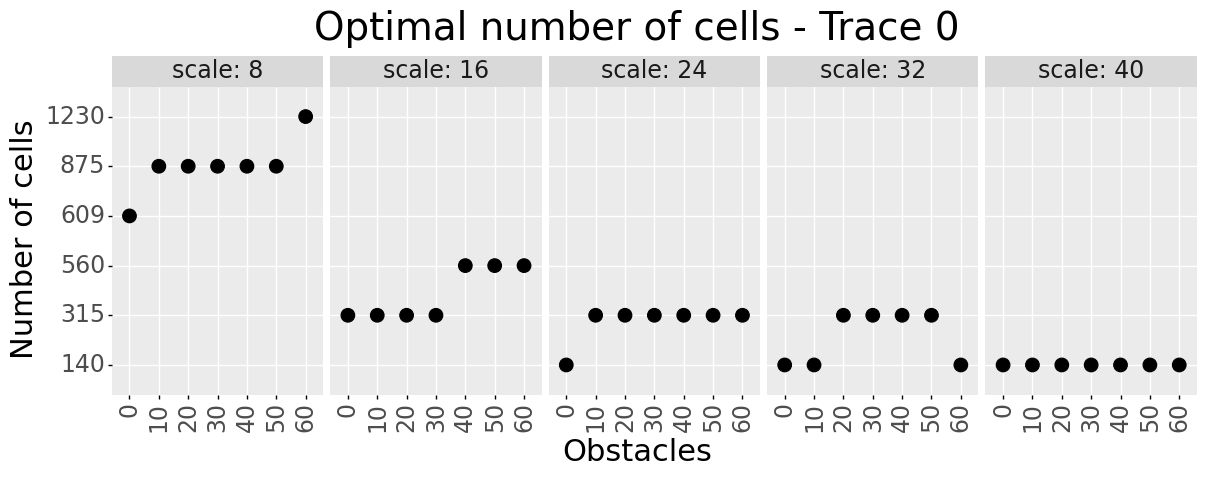

<ggplot: (116551296871)>

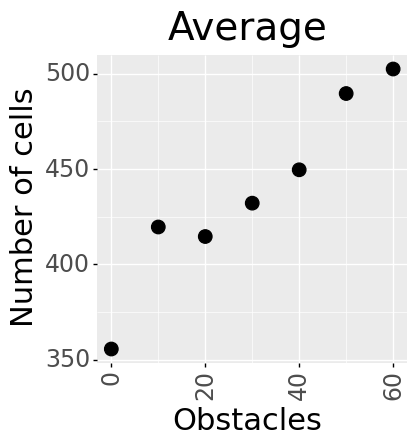

<ggplot: (116551309659)>

In [28]:
scales_for_plot = [8, 16, 24, 32, 40]

reset_gg_defaults()

# FIND BEST NUMBER OF CELLS FOR EACH SCALE AND NUMBER OF OBSTACLES, 
# average_results = summaries.groupby(['num_obstacles','scale','number of cells']).steps.mean().reset_index()
average_results = runtimes_last_episode.groupby(['num_obstacles','scale','number of cells']).steps.mean().reset_index()
best_num_cells = average_results.loc[average_results.groupby(['num_obstacles','scale']).steps.idxmin()].reset_index(drop=True)
mean_num_cells = best_num_cells.groupby(['num_obstacles'])['number of cells'].agg(['mean','std']).reset_index()
best_num_cells2 = best_num_cells.loc[best_num_cells.scale.isin(scales_for_plot)].astype('category')

# display(mean_num_cells)
                                                                         
# PLOTS:
p0 = ggplot(best_num_cells2, aes('num_obstacles', 'number of cells', color='num_obstacles'))
p0 += geom_point(position=position_dodge(width=0.5),size=5, color='k')
p0 += labs(x='Obstacles', y='Number of cells', color="Obstacles", title=f'Optimal number of cells - Trace {t}')
p0 += facet_grid(". ~ scale", labeller='label_both')
p0 += theme(
    axis_text_x=element_text(rotation=90, hjust=0.5),
    aspect_ratio=None,
    figure_size=(14,4)
)
display(p0)
ggsave(p0, folder_density_best_densities + f'e1_cells_vs_obstacles_per_scale-T{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(p0, folder_density_best_densities + f'e1_cells_vs_obstacles_per_scale-T{int(t*10)}MST.png', dpi=300, verbose = False)

p2 = ggplot(mean_num_cells, aes('num_obstacles', 'mean'))
p2 += labs(x='Obstacles', y='Number of cells', title=f'Average')
p2 += geom_point(size=5)
p2 += theme(
    aspect_ratio = None,
    figure_size = (4,4),        
    # plot_title = element_text(size = 28)
)
display(p2)
ggsave(p2, folder_density_best_densities + f'e1_cells_vs_obstacles-T{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(p2, folder_density_best_densities + f'e1_cells_vs_obstacles-T{int(t*10)}MST.png', dpi=300, verbose = False)

if False:
    p1 = ggplot(best_num_cells2, aes('scale', 'number of cells', color='scale'))
    p1 += labs(x='Scale', y='Number of cells', color="Scale", title=f'Optimal number of cells - Trace {t}')
    p1 += geom_point(position=position_dodge(width=0.5),size=3)
    p1 += facet_grid(". ~ num_obstacles")
    # p1 += theme_dark()
    p1 += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5),
        figure_size=(15,3)
    )
    display(p1)
    ggsave(p1, folder_density_best_densities + f'cells_vs_scale_per_obstacles-T{int(t*10)}.pdf', dpi=300, verbose = False, width=8, height=4)

    p3 = ggplot(best_num_cells, aes('factor(num_obstacles)', 'number of cells'))
    p3 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p3 += labs(x='Obstacles')
    p3 += coord_cartesian(ylim=[0, 1000])
    p3 += theme(
        figure_size = (5,5)
    )
    display(p3)




## CELL CONTRIBUTION

In [107]:
# GET CONFIGURATIONS:
t = 0
configs_multi_layer = configs.loc[configs.pcs.str.contains('ml') & (configs.traces == t)].copy()
configs_multi_layer['num_obstacles'] = configs_multi_layer.maze.map(lambda m : int(m[1])*10).astype('category')

def load_paths(file_paths, num_paths):
    with open( file_paths, 'rb') as file:
        return [load_float_vector(file).reshape((-1, 2)) for i in range(num_paths)]

def filter_turns(paths):
    
    def filter_function(p):
        deltas = p[1:]-p[0:-1] # get delta position (displacement vector)
        is_turn = np.abs(deltas[0:-1]-deltas[1:]).sum(axis=1) > 0.001 # current delta position, must be different to next delta
        return p[1:-1][is_turn] # not only mid points can be turns

    return np.concatenate([filter_function(p) for p in paths])
    
def softmax(matrix):
    # calculate softmax of each row
    # note substracting a constant element does not afect softmax result but helps prevents e^"really big number" = infinity (due to float precision)
    exponential = np.exp(matrix - matrix.max(axis=1).reshape(-1, 1))
    return exponential / exponential.sum(axis=1).reshape(-1,1)
    
    
def activate_place_cells(pcs, positions):
    
    # CONSTANTS - see place cells in java 
    num_cells = len(pcs)
    num_pos   = positions.shape[0]
    
    # FIND DISPLACEMENT VECTOR FOR ALL PCS AND RAT POSITIONS     
    xy = np.repeat(positions, len(pcs), axis=0)          # rat positions to be calculated
    xi = np.tile(pcs[['x', 'y']].to_numpy(),(num_pos,1)) # place cell centers x_i
    deltas = xy - xi
    
    # calculate gaussians and set  activations outside of radius to 0 
    norm2 = np.einsum('ij,ij->i', deltas, deltas).reshape(num_pos, num_cells) # multiply tensors, contract row (calculates norm^2 of each row)
    activations = np.exp(norm2 * pcs['ks'].to_numpy())    
    activations[norm2 > pcs['r2'].to_numpy()] = 0
    
    # normalize and return results 
    return activations / activations.reshape((-1, num_cells)).sum(axis=1).reshape(-1,1)    


def calculate_local_contributions_V(pcs, activations, values):
    # parameters
    num_cells = len(pcs)
    num_positions = int(activations.shape[0])
    
    method = 1
    
    # each method may choose whether:
    # - use abs values
    # - aggregate all locations
    # - choose a normalizer (such as max contrib or sum of contribs)
    if method == 1: # contrib = P_i*V_i 
        # calculate contributions of each place cell, then sum contributions for each position and normalize results
        # contributions = activations * np.abs(values) 
        contributions = activations * values
        normalized_contribs = contributions / (contributions.sum(axis=1) / 100).reshape(-1,1) # note: divide by 100 so that results are in range 0-100 instead of 0-1
        normalized_contribs = normalized_contribs.reshape(-1)
        
        ids = normalized_contribs != 0
        pc_sizes = np.tile(pcs['r'].to_numpy(), num_positions)
        locations = np.repeat(np.arange(num_positions), num_cells)
        local_contribs = pd.DataFrame({'position':locations[ids], 'r':pc_sizes[ids], 'contribution':normalized_contribs[ids]})
        
        local_contribs = np.abs(local_contribs.groupby(['position', 'r']).sum()).reset_index()        

        total_contribs = local_contribs[['r','contribution']].groupby(['r']).sum().reset_index() # Sum all positions (drop positon, group by r, sum results)
        total_contribs.contribution = total_contribs.contribution / num_positions  # normalized based on number of positions
        return total_contribs
#         return local_contribs
        
        
    elif method == 2: # contrib = P_i*(V_i - V) 
        # calculate V for each position
        init_contribs = activations * values                       # for each position, multiply activation and value of each cell
        value_x = init_contribs.sum(axis=1).reshape(-1,1)          # calculate value function at each position
        relative_contribs = init_contribs - activations * value_x  # calculate the relative contributions of each cell
#         relative_contribs = np.abs(relative_contribs)
#         normalized_contribs = (relative_contribs / np.abs(relative_contribs).max(axis=1).reshape(-1,1)).reshape(-1)*100 # normalize by max activation so that range is always in [0-100], revert matrix back to vector
        normalized_contribs = relative_contribs.reshape(-1)
    
        ids = normalized_contribs != 0
        pc_sizes = np.tile(pcs['r'].to_numpy(), num_positions)
        local_contribs = pd.DataFrame({'r':pc_sizes[ids], 'contribution':normalized_contribs[ids]})
        total_contribs = local_contribs.groupby(['r']).sum().reset_index()
        total_contribs.contribution = total_contribs.contribution / num_positions
        return total_contribs
#         return local_contribs


def calculate_contributions_Q(pcs, p_xi, q_ij):
    r_indices = {str(int(r*100)) : (pcs.r.to_numpy() == r) for r in pcs['r'].unique()}
    rs = set(r_indices.keys()) # 0.04, 0.16, 52
    
    # calculate Q for each scale,total Q and the complement of each scale ( Q - Q_r )
    Q_r_xj = { r : np.einsum('xi,ij->xj', p_xi[:, indices], q_ij[indices]) for r, indices in r_indices.items() } # Q for each scale
    Q_xj = np.sum(list(Q_r_xj.values()), axis = 0) # total Q
    _Q_r_xj = { r : Q_xj - Q_r for r, Q_r in Q_r_xj.items()} # complements
    
    # calculate probabilities of each action:
#     pi_xj = softmax(Q_xj)
#     _pi_r_xj = { r : softmax(Q) for r, Q in _Q_r_xj.items() }
    
    
    # find best actions for each position in total Q and the complements
    a = Q_xj.argmax(axis=1)
    _a_r = { r : _Q_r.argmax(axis=1) for r, _Q_r in _Q_r_xj.items()}
    
    # we define the contribution of a scale as the number of positions where the action chosen by deactivating the layer difers from the actual action
    num_pos = p_xi.shape[0]
    q_contribs = {r : (a != _a).sum() / num_pos for r, _a in _a_r.items()}
#     q_contribs = {r : (a != _a).sum()  for r, _a in _a_r.items()}
    q_contribs_df = pd.DataFrame(list(q_contribs.items()), columns = ['r','contribution'])
    
    
    
    
    # NEW METHOD
    def get_norm(a):
        return np.sqrt(np.einsum('ij,ij->i', a, a))
    q_norms = get_norm(Q_xj)
    
    
    q_cont = { r : (get_norm(qr)  / q_norms).sum()*100 / num_pos  for r, qr in Q_r_xj.items() }
    q_contribs_df = pd.DataFrame(list(q_cont.items()), columns = ['r','contribution'])
    
    return q_contribs_df
    

def get_pc_contributions_from_rat(pcs, folder, rat, config_id, num_start_locations):
    # PATHS TO DATA
    file_paths = f'{folder}r{rat}-paths.bin'
    file_V = f'{folder}r{rat}-V0.bin'
    file_Q = f'{folder}r{rat}-Q0.bin'
    
    # LOAD DATA
    V_i = load_float_vector(file_V) # load state values
    Q_ij = load_float_matrix(file_Q) # load action values

    # GET POSITIONS IN PATHS AND GET POSITIONS WHERE RAT TURNS
    paths = load_paths(file_paths, num_start_locations)
    all_positions = np.concatenate(paths) # load positions
    turns = filter_turns(paths)
    turns_df = pd.DataFrame({'config':[config_id], 'turns':[len(turns)], 'path length':[len(all_positions)]})
    
    
    # CALCULATE PC ACTIVATIONS
    positions = turns if TURNS_ONLY else all_positions
    activations = activate_place_cells(pcs, positions) # calculate pc activations
    
    
    # CALCULATE V CONTRIBUTIONS
    contributions_v = calculate_local_contributions_V(pcs, activations, V_i)
    contributions_v['config'] = config_id
    
    # CALCULATE Q CONTRIBUTIONS
    contributions_q = calculate_contributions_Q(pcs, activations, Q_ij)
    contributions_q['config'] = config_id

    
    return contributions_v, contributions_q, turns_df
    
def get_pc_contributions_from_config(config_id, config):
    # GET FILE NAMES
    folder_config = os.path.join(folder, 'configs', config_id, '')
    file_pc = config['pc_files']
    num_start_locations = int(config['numStartingPositions'])

    # LOAD PCS, ADD EXTRA FIELDS TO CALCULATE ACTIVATIONS
    pcs = pd.read_csv(file_pc)
    cell_count = pcs.groupby(['r']).count()
    
    tolerance = 0.01
    min_activation = 0.001
    pcs['r_tol'] = pcs['r'] + tolerance
    pcs['r2'] = pcs['r_tol'] ** 2
    pcs['ks'] = np.log(min_activation) / pcs['r2']
    
#     display(pcs)
#     display(cell_count)
      

    # GET CONTRIBUTION OF EACH RAT (use only 10 rats)
    contribs_turns = [get_pc_contributions_from_rat(pcs, folder_config, rat, config['c_id'], num_start_locations) for rat in range(0,10)] # UNDO : range should be 10
    contribs_v, contribs_q, turns = (pd.concat(d).reset_index(drop=True) for d in zip(*contribs_turns))
    return contribs_v, contribs_q, turns
    
def get_contribs(turns_only):
    global TURNS_ONLY
    TURNS_ONLY = turns_only
    # display(get_pc_contributions_from_config('c13044', configs_multi_layer.loc['c13044'])) # UNDO: replace line with next line
    config_contribs_and_turns = [get_pc_contributions_from_config(config_id, config) for config_id, config in configs_multi_layer.iterrows()]
    config_contributions_v, config_contributions_q, config_turns = ( concat_augment(d)  for d in zip(*config_contribs_and_turns))
    config_contributions_v['r_d'] = (config_contributions_v.r * 100).astype('int').astype('category')
    config_contributions_q['r_d'] = (config_contributions_v.r * 100).astype('int').astype('category')
    
    return config_contributions_v, config_contributions_q, config_turns
    
# for each config, load pcs, for each rat load V, Q and paths during last episode, finally compute contribution of each non zero pc
concat_augment = lambda data : augment_data(pd.concat(data).reset_index(drop=True), configs_multi_layer, ['maze', 'num_obstacles'])


config_contributions_v_turns, config_contributions_q_turns, config_turns = get_contribs(turns_only=True)
config_contributions_v_all, config_contributions_q_all, config_turns = get_contribs(turns_only=False)

# CALCULATE DIFFERENCE:
config_contributions_v_turns['diff'] = config_contributions_v_turns.contribution - config_contributions_v_all.contribution
config_contributions_q_turns['diff'] = config_contributions_q_turns.contribution - config_contributions_q_all.contribution

# CREATE FOLDERS FOR EXPERIMENT
folder_contributions = os.path.join(figure_folder, 'contributions/')
make_folder(folder_contributions)




# configs
# display(config_contributions_v)
# display(config_contributions_q)
# display(configs_multi_layer)
display('Done')

'Done'

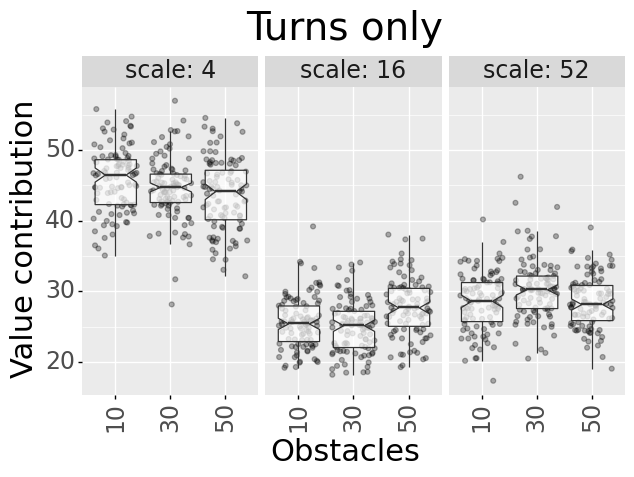

<ggplot: (115833994698)>

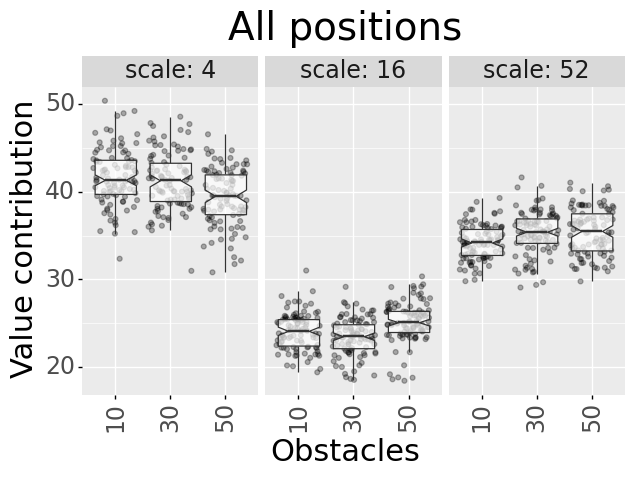

<ggplot: (115834092990)>

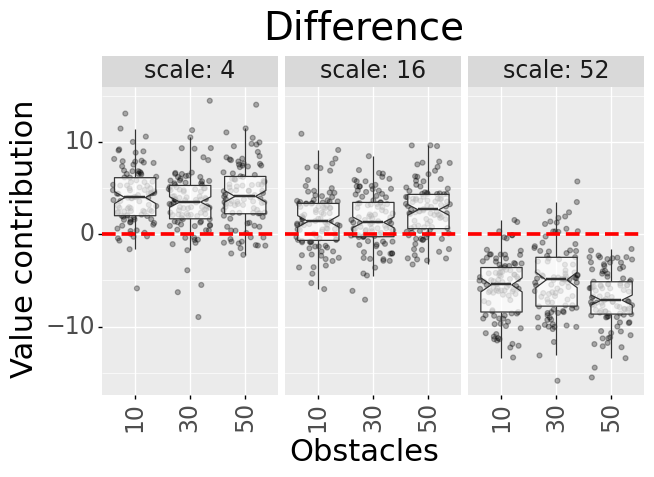

<ggplot: (115833695458)>

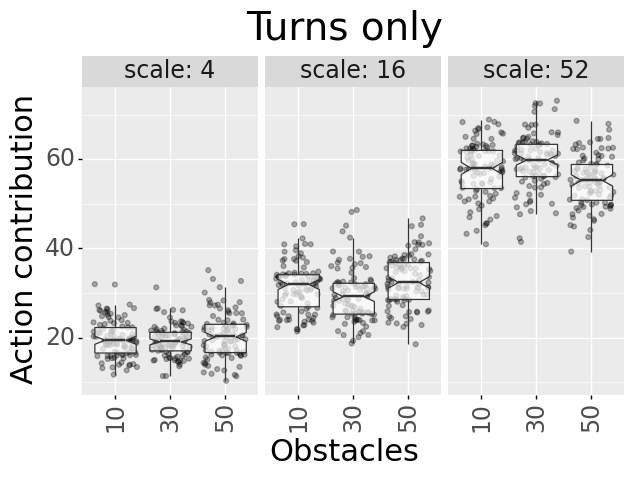

<ggplot: (115830151940)>

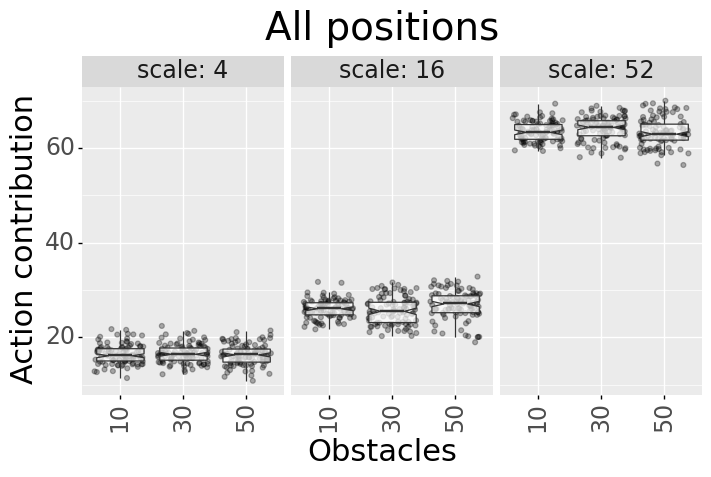

<ggplot: (115834016247)>

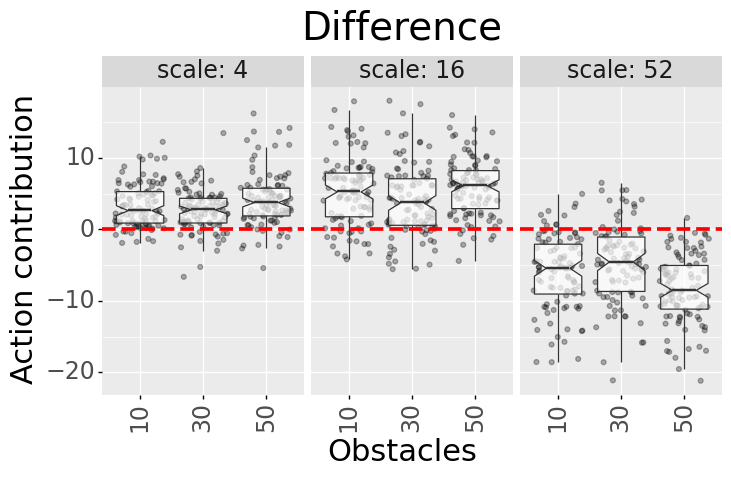

<ggplot: (115833075149)>

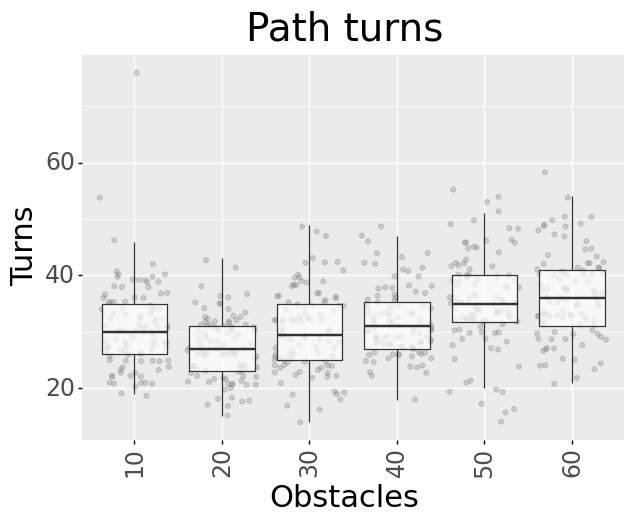

<ggplot: (115833108730)>

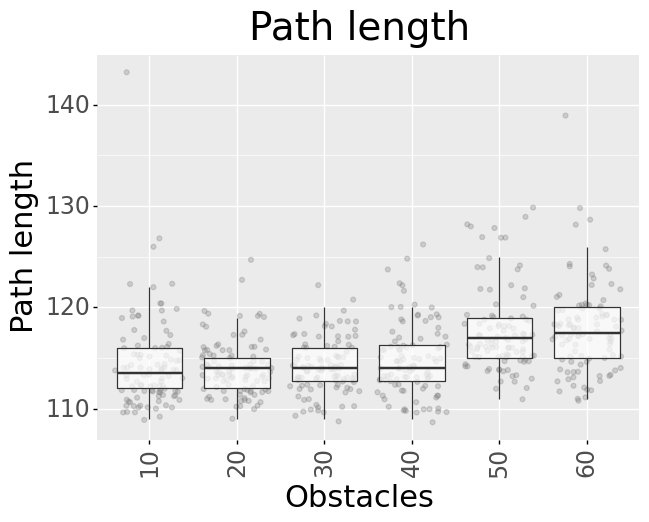

<ggplot: (115832733040)>

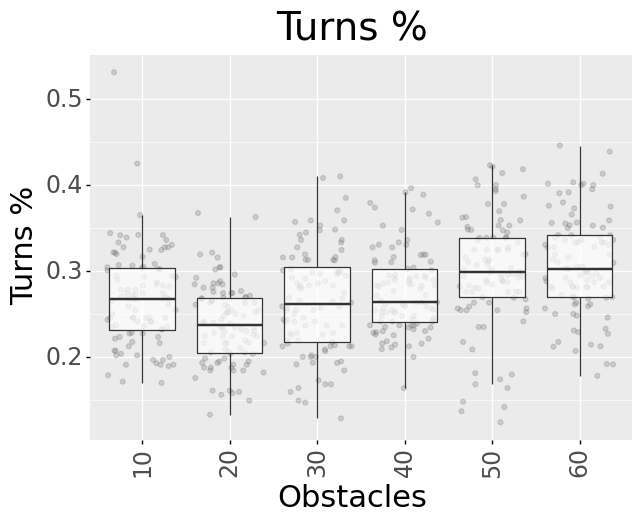

<ggplot: (115832574202)>

In [108]:
reset_gg_defaults()

obstacle_set=[10,30,50]
contrib_v_turns = config_contributions_v_turns.loc[config_contributions_v_turns.num_obstacles.isin(obstacle_set)].copy()
contrib_q_turns = config_contributions_q_turns.loc[config_contributions_q_turns.num_obstacles.isin(obstacle_set)].copy()
contrib_v_all = config_contributions_v_all.loc[config_contributions_v_all.num_obstacles.isin(obstacle_set)].copy()
contrib_q_all = config_contributions_q_all.loc[config_contributions_q_all.num_obstacles.isin(obstacle_set)].copy()

contrib_v_turns['obstacles'] = contrib_v_turns.num_obstacles
contrib_q_turns['obstacles'] = contrib_q_turns.num_obstacles
contrib_v_all['obstacles'] = contrib_v_all.num_obstacles
contrib_q_all['obstacles'] = contrib_q_all.num_obstacles

contrib_v_turns['scale'] = contrib_v_turns.r_d
contrib_q_turns['scale'] = contrib_q_turns.r_d
contrib_v_all['scale'] = contrib_v_all.r_d
contrib_q_all['scale'] = contrib_q_all.r_d

miny, maxy = contrib_v_turns.contribution.min(), contrib_v_turns.contribution.max()
buffer = 0.1*(maxy-miny)
lims = [miny - buffer, maxy+buffer]
# lims = [0, 120]


def plot_box_plot_turns(data, x_column, y_column, fill_column, x_title, y_title, plot_title, notches=True):
    p0 = ggplot(data, aes(x_column, y_column ))
    p0 += geom_jitter(alpha=0.3, position=position_jitter(), color='gray')
    p0 += geom_boxplot(alpha=0.7, notch=notches, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)       
    return p0

def plot_box_plot2(data, x_column, y_column, facet_column, x_title, y_title, plot_title, lims, notches=True):
    p0 = ggplot(data, aes(x_column, y_column )) # fill=x_column
    p0 += facet_grid(f'. ~ {facet_column}', scales='free', labeller='label_both')
    p0 += geom_jitter(alpha=0.3, position=position_jitter())
    p0 += geom_boxplot(alpha=0.7, notch=notches, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title) # fill=x_title
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    # p0 += coord_cartesian(ylim=lims)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

plt.close('all')

zero_line = geom_hline(yintercept=0, linetype="dashed", color = "red", size=1.5)

def plot_title(trace, turns_only):
    return ("Turns only" if turns_only else "All positions") # + f' - Trace {trace}'

# plot VALUE CONTRIBUTION in SETS ALL POSITIONS and JUST TURNS, then plot THE DIFFERENCE
plot = plot_box_plot2(contrib_v_turns, 'obstacles', 'contribution', 'scale', 'Obstacles', 'Value contribution' , plot_title(t, True), lims)
plot += theme( figure_size = (7,4) )
display(plot)
ggsave(plot,   folder_contributions + f'e2_v_contribs_turns-t{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(plot,   folder_contributions + f'e2_v_contribs_turns-t{int(t*10)}MST.png', dpi=300, verbose = False)

plot = plot_box_plot2(contrib_v_all, 'obstacles', 'contribution', 'scale', 'Obstacles', 'Value contribution' , plot_title(t, False), lims)
plot += theme( figure_size = (7,4) )
display(plot)
ggsave(plot,   folder_contributions + f'e2_v_contribs_all-t{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(plot,   folder_contributions + f'e2_v_contribs_all-t{int(t*10)}MST.png', dpi=300, verbose = False)


plot = plot_box_plot2(contrib_v_turns, 'obstacles', 'diff', 'scale', 'Obstacles', 'Value contribution' , 'Difference', [-16,16])
plot += zero_line
plot += theme( figure_size = (7,4) )
display(plot)
ggsave(plot,   folder_contributions + f'e2_v_contribs_diff-t{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(plot,   folder_contributions + f'e2_v_contribs_diff-t{int(t*10)}MST.png', dpi=300, verbose = False)


# plot ACTION CONTRIBUTION  in SETS ALL POSITIONS and JUST TURNS, then plot THE DIFFERENCE
plot = plot_box_plot2(contrib_q_turns, 'obstacles', 'contribution', 'scale', 'Obstacles', 'Action contribution' , plot_title(t, True), [0, 0.4])
display(plot)
plot += theme( figure_size = (8,4) )
ggsave(plot, folder_contributions + f'e2_q_contribs_turns-t{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_contributions + f'e2_q_contribs_turns-t{int(t*10)}MST.png', dpi=300, verbose = False)

plot = plot_box_plot2(contrib_q_all, 'obstacles', 'contribution', 'scale', 'Obstacles', 'Action contribution' , plot_title(t, False), [0, 0.4])
display(plot)
plot += theme( figure_size = (8,4) )
ggsave(plot, folder_contributions + f'e2_q_contribs_all-t{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_contributions + f'e2_q_contribs_all-t{int(t*10)}MST.png', dpi=300, verbose = False)

plot = plot_box_plot2(contrib_q_turns, 'obstacles', 'diff', 'scale', 'Obstacles', 'Action contribution' , 'Difference', [-0.2, 0.2])
plot += zero_line
plot += theme( figure_size = (8,4) )
display(plot)
ggsave(plot, folder_contributions + f'e2_q_contribs_diff-t{int(t*10)}MST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_contributions + f'e2_q_contribs_diff-t{int(t*10)}MST.png', dpi=300, verbose = False)


# PLOT TURNS AND PATH LENGTH
plot = plot_box_plot_turns(config_turns, 'num_obstacles', 'turns', 'num_obstacles', 'Obstacles', 'Turns' , "Path turns", notches=False)
plot += theme( figure_size = (7,5) )
display(plot)
ggsave(plot, folder_contributions + 'e2_turnsMST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_contributions + 'e2_turnsMST.png', dpi=300, verbose = False)


plot = plot_box_plot_turns(config_turns, 'num_obstacles', 'path length', 'num_obstacles', 'Obstacles', 'Path length' , "Path length", notches=False)
plot += theme( figure_size = (7,5) )
display(plot)
ggsave(plot, folder_contributions + 'e2_stepsMST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_contributions + 'e2_stepsMST.png', dpi=300, verbose = False)

config_turns['proportion of turns'] = config_turns['turns'] / config_turns['path length']
plot = plot_box_plot_turns(config_turns, 'num_obstacles', 'proportion of turns', 'num_obstacles', 'Obstacles', 'Turns %' , "Turns %", notches=False)
plot += theme( figure_size = (7,5) )
display(plot)
ggsave(plot, folder_contributions + 'e2_stepsMST.pdf', dpi=300, verbose = False)
ggsave(plot, folder_contributions + 'e2_stepsMST.png', dpi=300, verbose = False)


if False:
    # save_name = f'Boxplots_Scale-T{int(t*10)}-l{lims[1]}.pdf'
    # print(f'      PLOT: BOXPLOT - {save_name}')
    # r2 = runtimes_last_episode[runtimes_last_episode.scale > 4].copy()
    # r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
    # r2['scale_d'] = pd.Categorical(r2['scale'], np.sort(r2['scale'].unique())) 
    # box_plot_scale = plot_box_plot(r2, 'scale_d', 'steps', 'num_cells', 'PC Radius (cm)', 'Extra Steps', 'Number of Cells' , plot_title, lims)
    # ggsave(box_plot_scale, folder_density_obstacle_num + save_name, dpi=300, verbose = False)
    pass


config  location  rat  episode     steps   c_id num_obstacles
0      13044       255    0     9995  0.010870  13044            10
1      13044       255    1     9995  0.072752  13044            10
2      13044       255    2     9995  0.033784  13044            10
3      13044       255    3     9995  0.044121  13044            10
4      13044       255    4     9995  0.084736  13044            10
...      ...       ...  ...      ...       ...    ...           ...
5905   13162       255    5     9995  0.061899  13162            60
5906   13162       255    6     9995  0.087432  13162            60
5907   13162       255    7     9995  0.105591  13162            60
5908   13162       255    8     9995  0.061899  13162            60
5909   13162       255    9     9995  0.042668  13162            60

[600 rows x 7 columns]

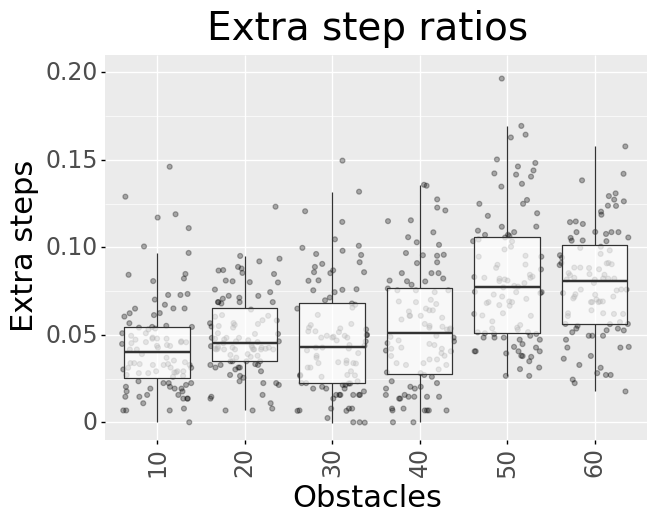

<ggplot: (115834565428)>

c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/contributions/e2_extra_stepsMST.pdf
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/contributions/e2_extra_stepsMST.png


In [105]:
# PLOT FINAL EXTRA STEPS RATIOS PER OBSTACLE 
# GET AND AUGMENT DATA
merge_fields = ['num_obstacles']
episode = lastEpisode(configs_multi_layer, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, configs_multi_layer, merge_fields, episode, location, skip_summary=True)
runtimes_last_episode = runtimes_last_episode.loc[runtimes_last_episode.rat < 10]
display(runtimes_last_episode)

# PLOT FINAL EXTRA STEPS 
p = ggplot(runtimes_last_episode, aes('num_obstacles', 'steps')) 
p += labs(x='Obstacles', y='Extra steps', title='Extra step ratios')
p += geom_jitter(alpha=0.3, position=position_jitter())
p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
p += coord_cartesian(ylim=[0,0.2])
p += theme( figure_size = (7,5) )

display(p)
ggsave(p , folder_contributions + 'e2_extra_stepsMST.pdf')
ggsave(p , folder_contributions + 'e2_extra_stepsMST.png')




## Path turns

'kruskal=KruskalResult(statistic=103.58052135681444, pvalue=9.290266219847954e-21)'

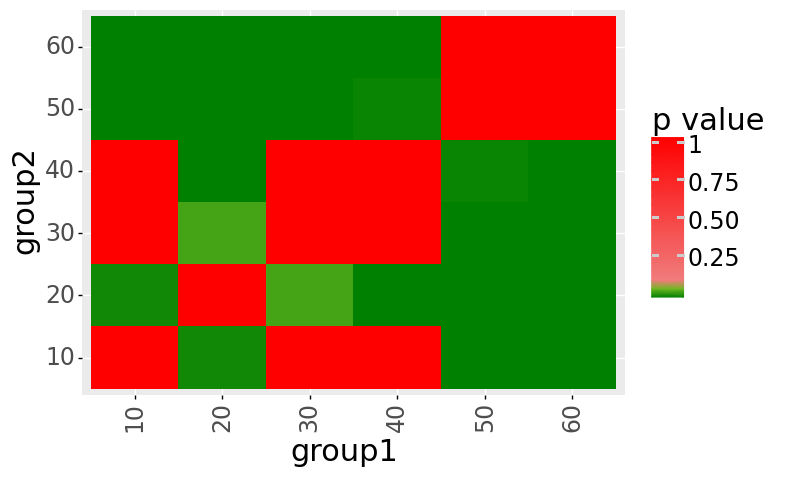

<ggplot: (115832507064)>

## Path Lengths

'kruskal=KruskalResult(statistic=110.70259180756413, pvalue=2.9107725745477535e-22)'

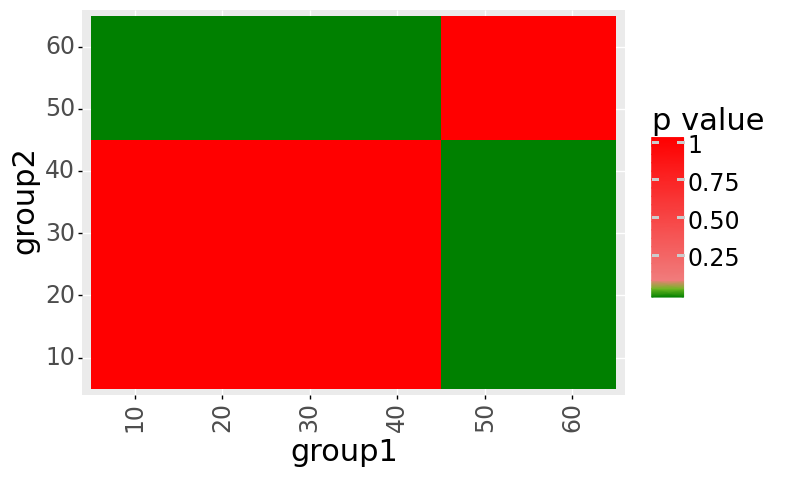

<ggplot: (115834204426)>

## Extra step ratios

'kruskal=KruskalResult(statistic=120.52117325432711, pvalue=2.434100149711815e-24)'

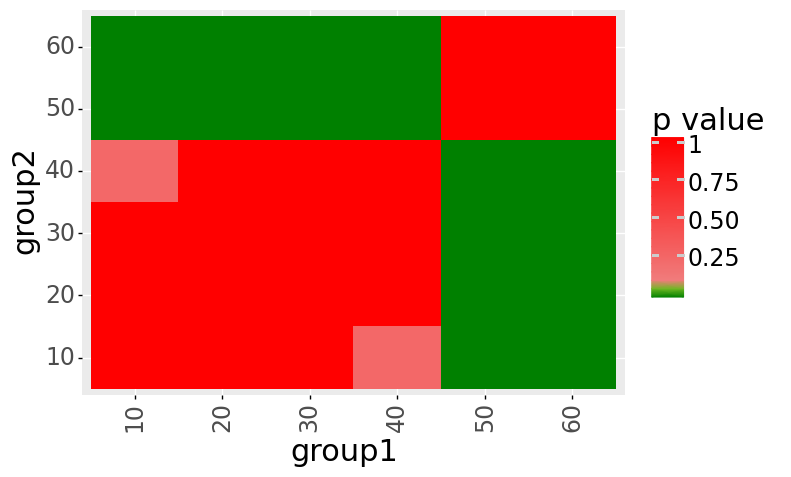

<ggplot: (115833433447)>

## ALL - v - scale 4

'kruskal=KruskalResult(statistic=40.936463227953254, pvalue=9.6642085081459e-08)'

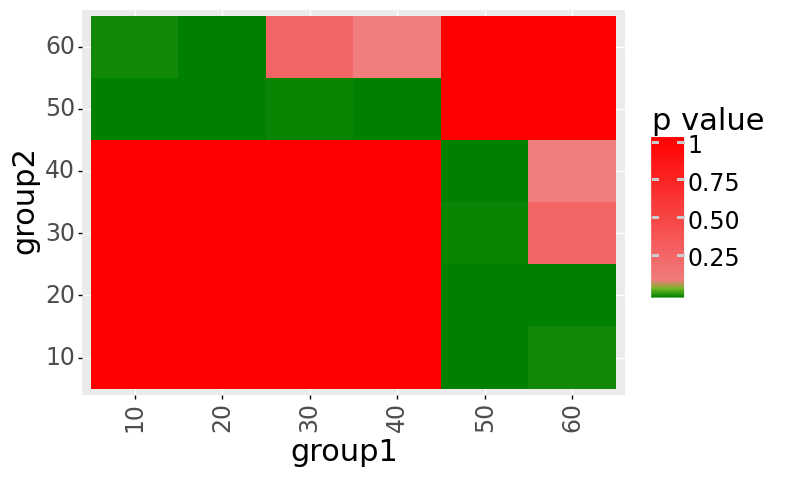

<ggplot: (115833579234)>

## ALL - v - scale 16

'kruskal=KruskalResult(statistic=76.25504359400998, pvalue=5.0888597735022605e-15)'

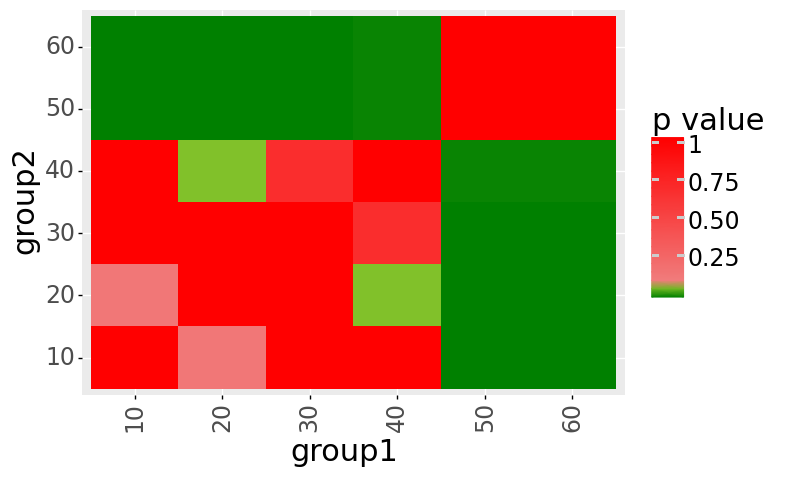

<ggplot: (115832410356)>

## ALL - v - scale 52

'kruskal=KruskalResult(statistic=20.21746222961724, pvalue=0.0011375685375311154)'

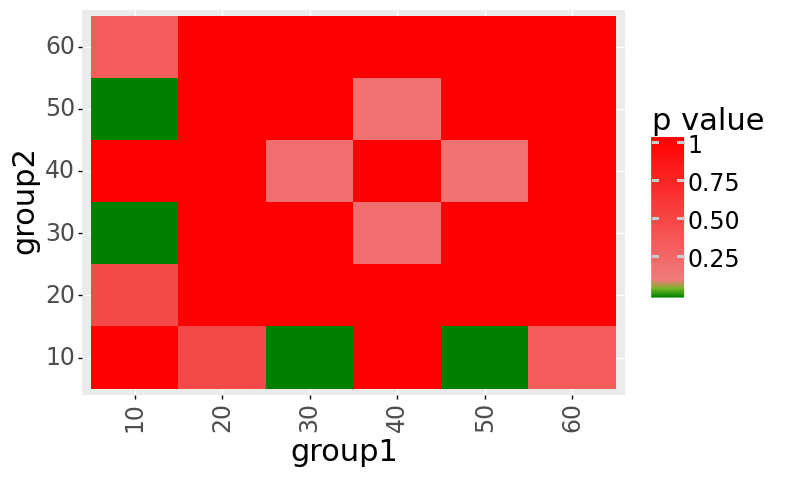

<ggplot: (115833699651)>

## TURNS - v - scale 4

'kruskal=KruskalResult(statistic=53.27782628951718, pvalue=2.9493273279660144e-10)'

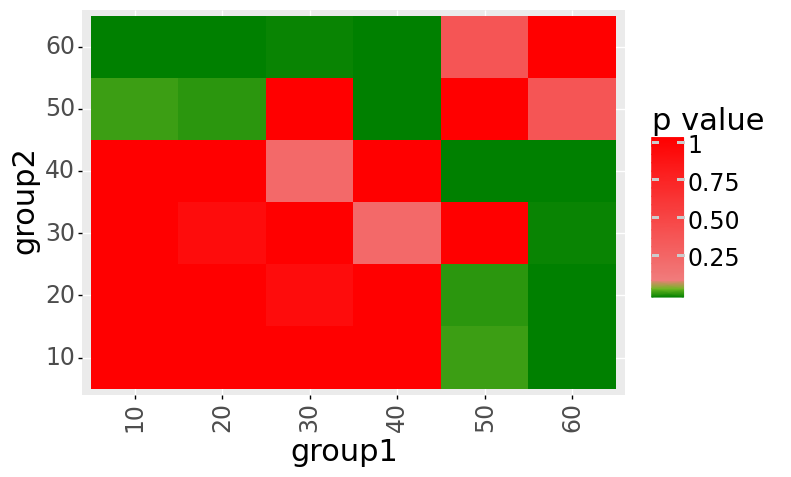

<ggplot: (115832500646)>

## TURNS - v - scale 16

'kruskal=KruskalResult(statistic=37.97465823627249, pvalue=3.8177271027785263e-07)'

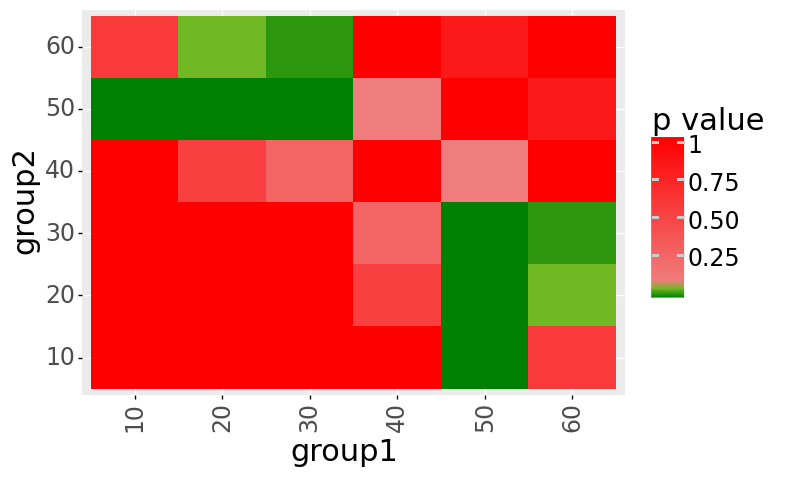

<ggplot: (115845965391)>

## TURNS - v - scale 52

'kruskal=KruskalResult(statistic=49.29437603993324, pvalue=1.93210258275235e-09)'

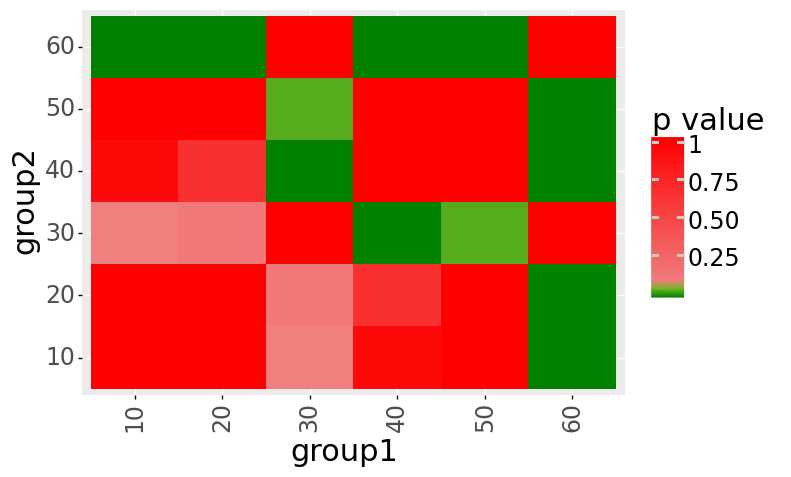

<ggplot: (115833301324)>

## ALL - q - scale 4

'kruskal=KruskalResult(statistic=18.84725324459191, pvalue=0.002052191809715766)'

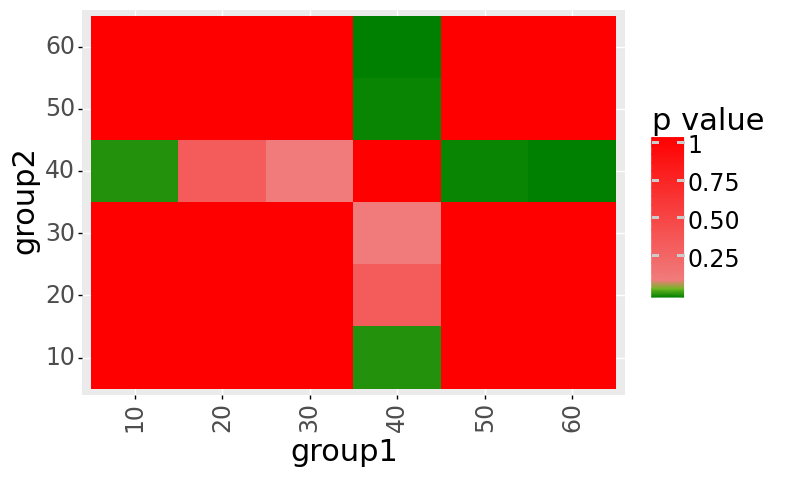

<ggplot: (115834722440)>

## ALL - q - scale 16

'kruskal=KruskalResult(statistic=40.744423294508806, pvalue=1.0566961784286511e-07)'

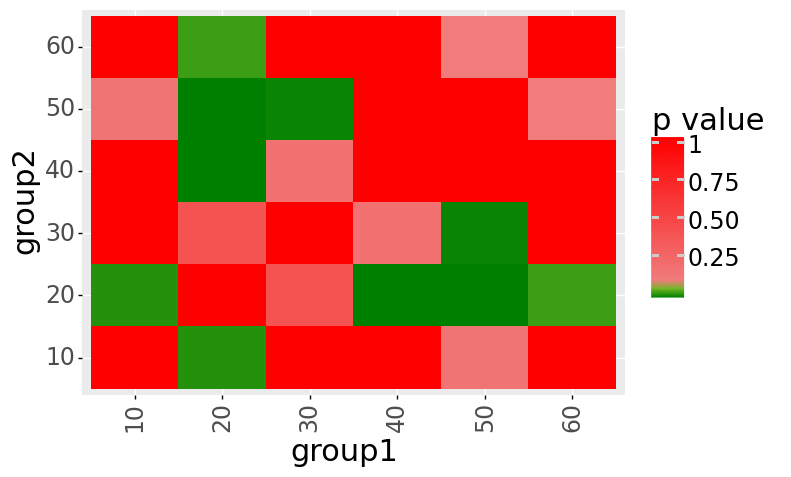

<ggplot: (115833608659)>

## ALL - q - scale 52

'kruskal=KruskalResult(statistic=36.836439933444126, pvalue=6.45909234122536e-07)'

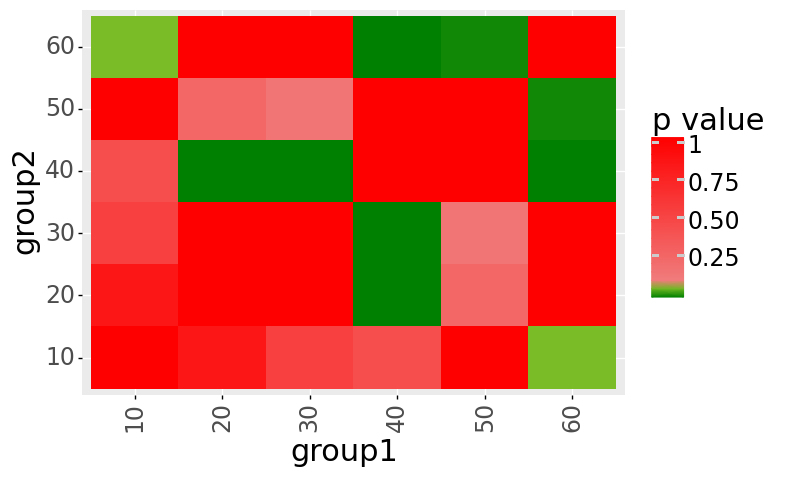

<ggplot: (115833716884)>

## TURNS - q -  scale 4

'kruskal=KruskalResult(statistic=45.07413710482501, pvalue=1.4013861937989502e-08)'

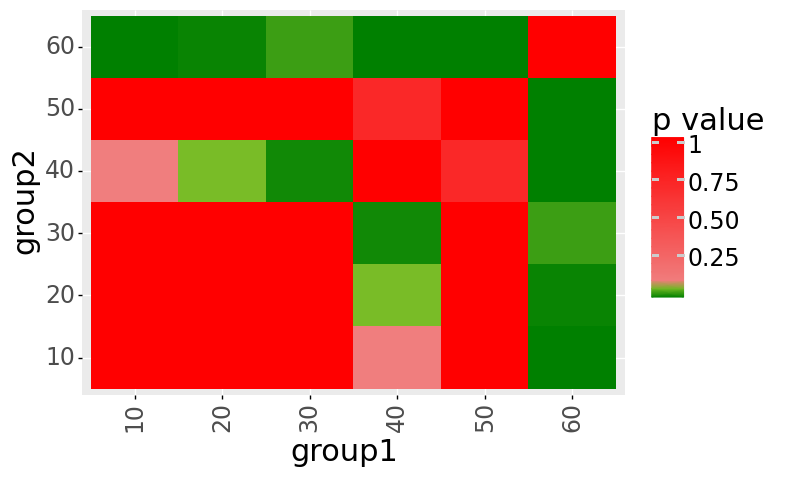

<ggplot: (115834572168)>

## TURNS - q -  scale 16

'kruskal=KruskalResult(statistic=37.89376971713796, pvalue=3.9632520353733363e-07)'

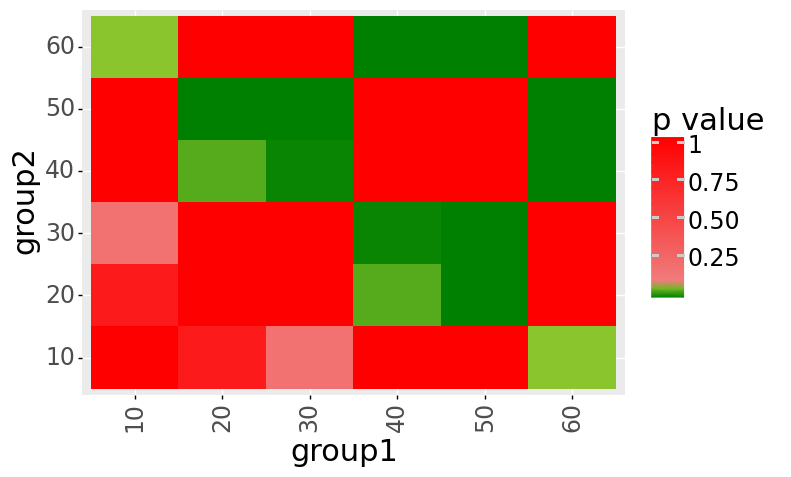

<ggplot: (116000855670)>

## TURNS - q -  scale 52

'kruskal=KruskalResult(statistic=80.94866222961696, pvalue=5.313102105261553e-16)'

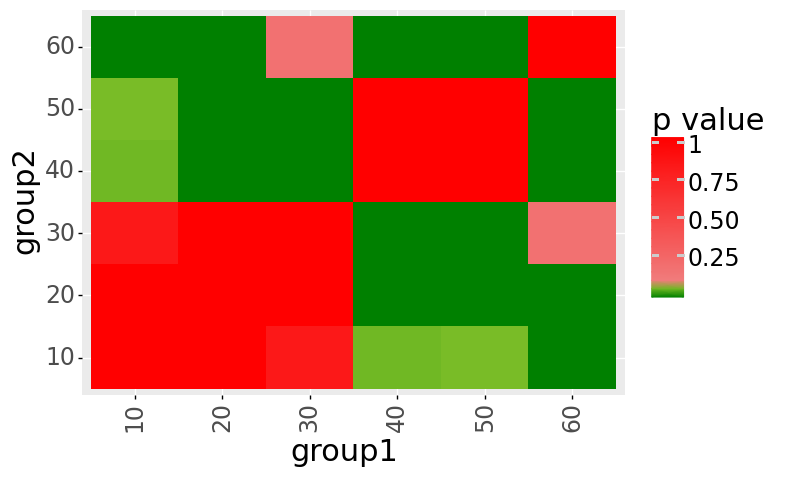

<ggplot: (115834639758)>

In [106]:
# statistical significance:

from scipy.stats import kruskal, f_oneway
from scikit_posthocs import posthoc_dunn as dunn_test

alpha = 0.07

k = kruskal(*[group["turns"].values for name, group in config_turns.groupby("num_obstacles")])
dunn=dunn_test(config_turns, val_col='turns', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
display(Markdown('## Path turns'))
display(f'kruskal={k}')
display(plot_pairwise_posthoc_test(dunn, alpha))


k = kruskal(*[group["path length"].values for name, group in config_turns.groupby("num_obstacles")])
dunn=dunn_test(config_turns, val_col='path length', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
display(Markdown('## Path Lengths'))
display(f'kruskal={k}')
display(plot_pairwise_posthoc_test(dunn, alpha))

k = kruskal(*[group["steps"].values for name, group in runtimes_last_episode.groupby("num_obstacles")])
dunn=dunn_test(runtimes_last_episode, val_col='steps', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
display(Markdown('## Extra step ratios'))
display(f'kruskal={k}')
display(plot_pairwise_posthoc_test(dunn, alpha))


for scale, scale_data in config_contributions_v_all.groupby(['r_d']):
    k = kruskal(*[group["contribution"].values for name, group in scale_data.groupby("num_obstacles")])
    dunn = dunn_test(scale_data, val_col='contribution', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
    
    display(Markdown(f'## ALL - v - scale {scale}'))
    display(f'kruskal={k}')
    display(plot_pairwise_posthoc_test(dunn, alpha))

for scale, scale_data in config_contributions_v_turns.groupby(['r_d']):
    k = kruskal(*[group["contribution"].values for name, group in scale_data.groupby("num_obstacles")])
    
    dunn = dunn_test(scale_data, val_col='contribution', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
    
    display(Markdown(f'## TURNS - v - scale {scale}'))
    display(f'kruskal={k}')
    display(plot_pairwise_posthoc_test(dunn, alpha))
    
for scale, scale_data in config_contributions_q_all.groupby(['r_d']):
    k = kruskal(*[group["contribution"].values for name, group in scale_data.groupby("num_obstacles")])
    dunn = dunn_test(scale_data, val_col='contribution', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
    
    display(Markdown(f'## ALL - q - scale {scale}'))
    display(f'kruskal={k}')
    display(plot_pairwise_posthoc_test(dunn, alpha))

for scale, scale_data in config_contributions_q_turns.groupby(['r_d']):
    k = kruskal(*[group["contribution"].values for name, group in scale_data.groupby("num_obstacles")])
    
    dunn = dunn_test(scale_data, val_col='contribution', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
    
    display(Markdown(f'## TURNS - q -  scale {scale}'))
    display(f'kruskal={k}')
    display(plot_pairwise_posthoc_test(dunn, alpha))




In [91]:
display(config_contributions_v_turns.anova(dv="contribution", between=[ "num_obstacles"]))

display(config_contributions_q_turns.anova(dv="contribution", between=["r_d", "num_obstacles"]))



Source             SS    DF            MS            F  \
0                  r_d  120769.943386     2  60384.971693  3178.746303   
1        num_obstacles       0.007686     5      0.001537     0.000081   
2  r_d * num_obstacles    3050.550441    10    305.055044    16.058509   
3             Residual   33851.716774  1782     18.996474          NaN   

          p-unc           np2  
0  0.000000e+00  7.810674e-01  
1  1.000000e+00  2.270513e-07  
2  5.339231e-28  8.266566e-02  
3           NaN           NaN

Source             SS    DF             MS            F  \
0                  r_d  460538.954007     2  230269.477004  7506.618713   
1        num_obstacles       6.393361     5       1.278672     0.041684   
2  r_d * num_obstacles    5952.721092    10     595.272109    19.405441   
3             Residual   54663.787212  1782      30.675526          NaN   

          p-unc       np2  
0  0.000000e+00  0.893898  
1  9.990187e-01  0.000117  
2  2.586259e-34  0.098203  
3           NaN       NaN

## SHORTEST paths

c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/contributions/e2_optimal_paths_plotMST.pdf
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/contributions/e2_optimal_paths_plotMST.png


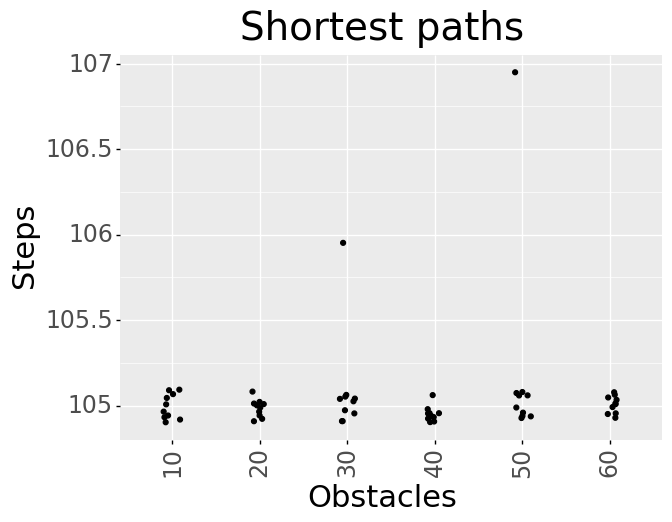

<ggplot: (118389280154)>

In [48]:
maze_metrics_file = 'experiments/mazes/mazeMetrics.csv'
maze_metrics = pd.read_csv(maze_metrics_file)
mazes = [f'M{i}{j:02d}.xml' for i in range(1,7) for j in range(19)]
maze_metrics = maze_metrics.loc[maze_metrics.maze.isin(mazes)][['maze','pos','steps']].copy().reset_index(drop=True)

maze_metrics2 = maze_metrics.groupby(['maze']).steps.sum().reset_index()
maze_metrics2['num_obstacles'] = maze_metrics2.maze.map(lambda s : s[1:-5])

# display(maze_metrics2)

# print('Min steps')
# display(maze_metrics.groupby(['pos']).steps.min())

# print('Max steps')
# display(maze_metrics.groupby(['pos']).steps.max())
noise = 0.1
p = ggplot(maze_metrics2, aes('num_obstacles', 'steps')) + geom_jitter(width=noise, height = noise) + labs( x='Obstacles', y='Steps', title='Shortest paths')
ggsave(p,folder_contributions + 'e2_optimal_paths_plotMST.pdf')
ggsave(p,folder_contributions + 'e2_optimal_paths_plotMST.png')
# print()
display(p)

# filter_mazes#
# maze_metrics.groupby(['pos'])

# Article plots

## Commom data

In [102]:
folder_article_figures = os.path.join(figure_folder, 'article_figures/')
folder_maze_figures = folder_article_figures + 'mazes/'
make_folder(folder_article_figures)
make_folder(folder_maze_figures)
# plt.close('all')

## Density experiment data

In [8]:
# CHOOSE PARAMETERS
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]
num_obstacles = [i*10 for i in range(7)]
layers = [f'u{4*i:02d}' for i in range(1,15)]
traces = [0, 0.7]

o = {num_obstacles[0], num_obstacles[6]}
t = traces[0]
l = layers[1]

# CREATE FOLDERS FOR EXPERIMENT
folder_density_obstacle_num = os.path.join(figure_folder, 'density_fixed_obstacle_num/')
make_folder(folder_density_obstacle_num)


# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0] == 'u') & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')
experiment_configs = experiment_configs[(experiment_configs.scale % 8 == 0)] # 


# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'scale', 'number of cells']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells']
# display(experiment_configs['number of cells'].unique())
display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
# display(learning_times)

c_id  maze  num_obstacles     pcs  scale  number of cells
config                                                            
c2          2    M0              0  u08_21      8              609
c4          4    M0              0  u08_25      8              875
c6          6    M0              0  u08_30      8             1230
c8          8    M0              0  u08_35      8             1680
c10        10    M0              0  u08_40      8             2200
...       ...   ...            ...     ...    ...              ...
c12968  12968  M609             60  u56_20     56              560
c12970  12970  M609             60  u56_25     56              875
c12972  12972  M609             60  u56_30     56             1230
c12974  12974  M609             60  u56_35     56             1680
c12976  12976  M609             60  u56_40     56             2200

[3294 rows x 6 columns]

In [154]:
learning_times.num_obstacles.unique()

array([ 0, 10, 20, 30, 40, 50, 60], dtype=int64)

## Learning time faceted by obstacles and num cells

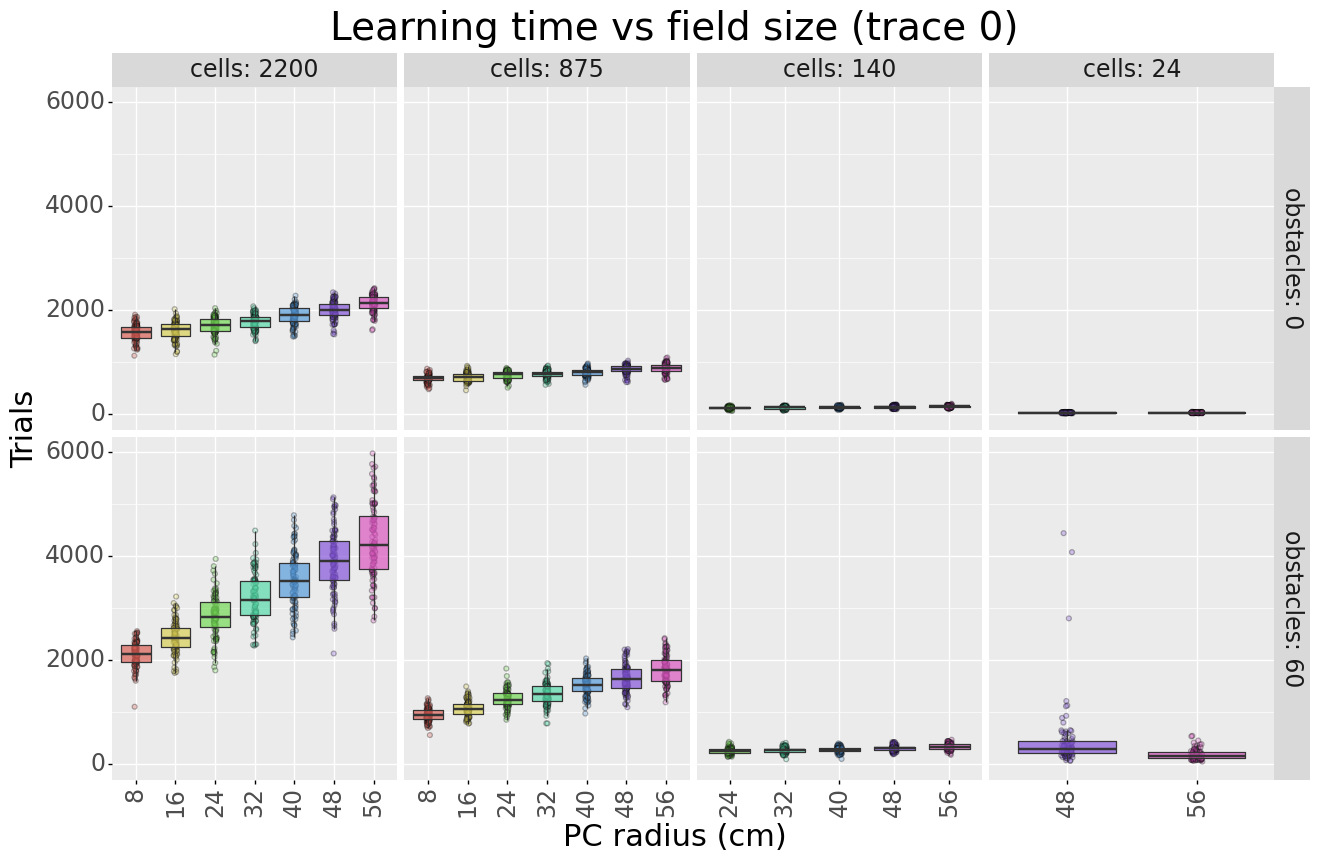

<ggplot: (116548598456)>

In [18]:
# counts = learning_times['number of cells'].value_counts()
plot_title = f'Learning time vs field size (trace {int(t*10)})'
x_title = f'PC radius (cm)'
y_title = f'Trials'
fill_title = f'PC radius (cm)'

plot_data = learning_times
plot_data = plot_data[ (plot_data['number of cells'].isin({2200, 875, 140, 24})) & (plot_data.num_obstacles.isin({0, 60}))]
plot_data = plot_data.copy()
# filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
plot_data['scale_d'] = pd.Categorical(plot_data['scale'], np.sort(plot_data['scale'].unique())) 
plot_data['cells'] = pd.Categorical(plot_data['number of cells'], np.sort(plot_data['number of cells'].unique())[::-1])
plot_data['obstacles'] = plot_data.num_obstacles

save_name = f'e1_learning_times_by_obstacles_and_cellsMST'



def do_plot():
    p = ggplot(plot_data, aes('scale_d', 'episode', fill='scale_d' ))
    p += facet_grid(f'obstacles ~ cells', scales='free_x', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group='scale_d'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x=x_title, y=y_title, title=plot_title, fill=fill_title)
    p += coord_cartesian(ylim=[0, 6000])
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(im_width, im_height)
    )
    return p


im_width, im_height = 15, 9
p = do_plot()



%matplotlib inline

# plt.rcParams['figure.figsize'] = [im_width, im_height]
ggsave(p, folder_article_figures + save_name + '.pdf', dpi=300, verbose = False)
ggsave(p, folder_article_figures + save_name + '.png', dpi=300, verbose = False)

display(p)


## Learning time faceted by obstacles and scale scale

[8, 32, 48]
Categories (3, int64): [8, 32, 48]

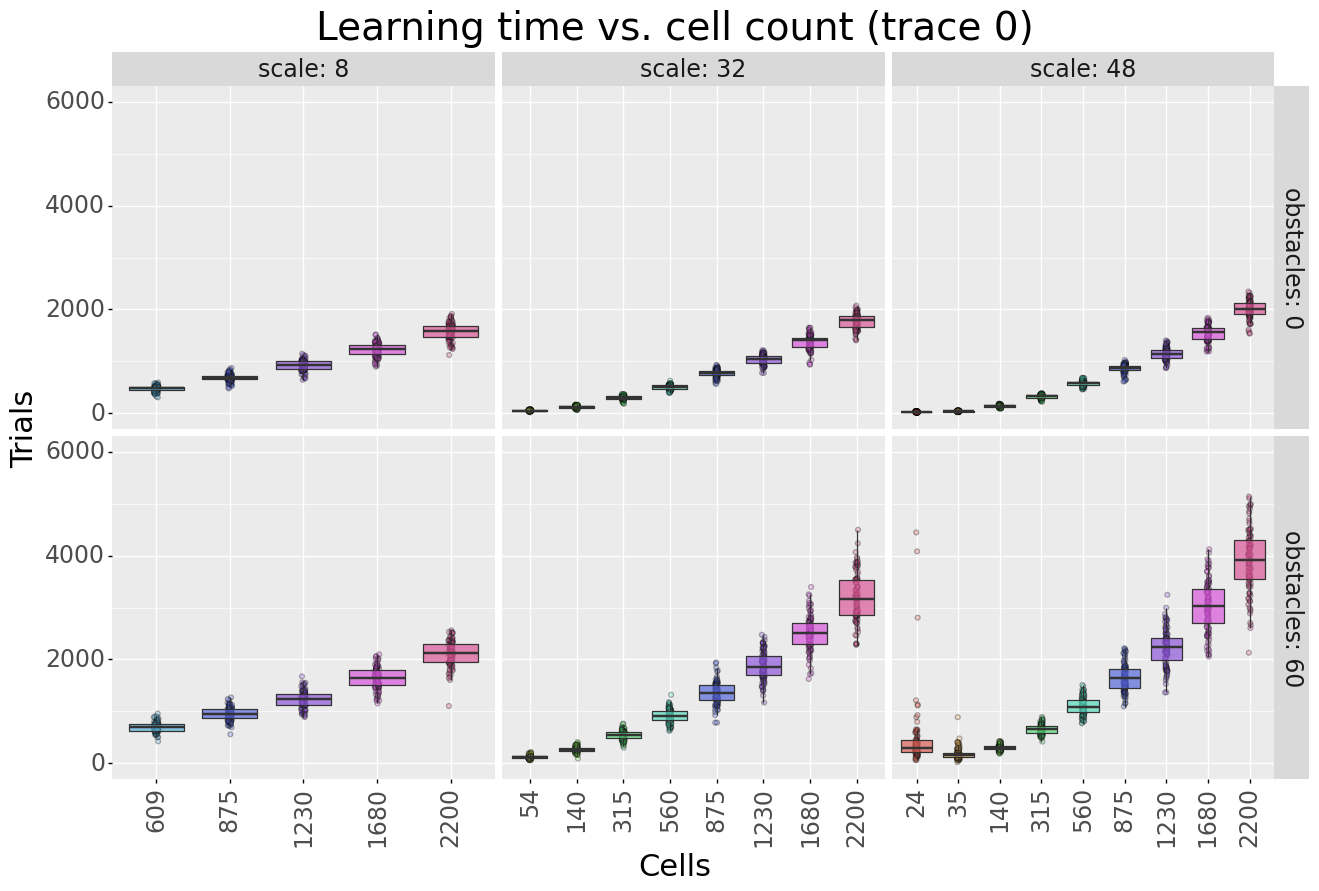

<ggplot: (116549162990)>

In [19]:
# counts = learning_times['number of cells'].value_counts()
plot_title = f'Learning time vs. cell count (trace {int(t*10)})'
x_title = f'Cells'
y_title = f'Trials'
fill_title = f'Cells'

plot_data = learning_times
plot_data = plot_data[ (plot_data['scale'].isin({8, 32, 48})) & (plot_data.num_obstacles.isin({0, 60}))]
plot_data = plot_data.copy()
# filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
plot_data['scale'] = pd.Categorical(plot_data['scale'], np.sort(plot_data['scale'].unique())) 
plot_data['cells'] = pd.Categorical(plot_data['number of cells'], np.sort(plot_data['number of cells'].unique())[::1])
plot_data['obstacles'] = plot_data.num_obstacles

save_name =  f'e1_learning_times_by_obstacles_and_scalesMST'


def do_plot():
    p = ggplot(plot_data, aes('cells', 'episode', fill='cells' ))
    p += facet_grid(f'obstacles ~ scale', scales='free_x', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group='cells'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x=x_title, y=y_title, title=plot_title, fill=fill_title)
    p += coord_cartesian(ylim=[0, 6000])
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(im_width, im_height)
    )
    return p


im_width, im_height = 15, 9
p = do_plot()



%matplotlib inline

# # plt.rcParams['figure.figsize'] = [im_width, im_height]
ggsave(p, folder_article_figures + save_name + '.pdf', dpi=300, verbose = False)
ggsave(p, folder_article_figures + save_name + '.png', dpi=300, verbose = False)

display(plot_data.scale.unique())
display(p)


## Learning time faceted by num cells and scale

[8, 32, 56]
Categories (3, int64): [8, 32, 56]

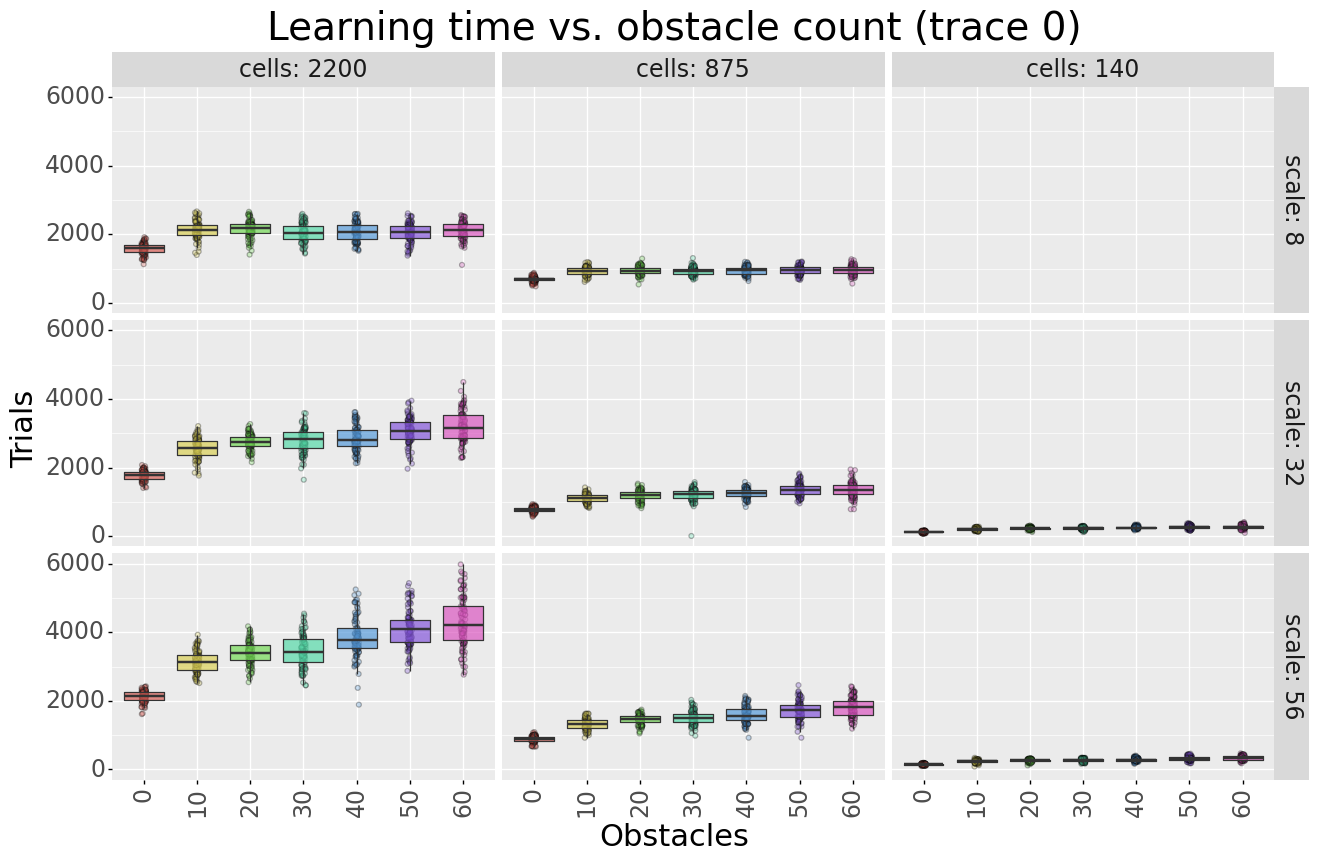

<ggplot: (116548457951)>

In [20]:
# counts = learning_times['number of cells'].value_counts()
plot_title = f'Learning time vs. obstacle count (trace {int(t*10)})'
x_title = f'Obstacles'
y_title = f'Trials'
fill_title = x_title

plot_data = learning_times
plot_data = plot_data[ (plot_data['scale'].isin({8, 32, 56}) & plot_data['number of cells'].isin({2200, 875, 140}))]
plot_data = plot_data.copy().reset_index(drop=True)
# filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
plot_data['scale'] = pd.Categorical(plot_data['scale'], np.sort(plot_data['scale'].unique())) 
plot_data['cells'] = pd.Categorical(plot_data['number of cells'], np.sort(plot_data['number of cells'].unique())[::-1])
plot_data['obstacles'] = pd.Categorical(plot_data.num_obstacles, np.sort(plot_data['num_obstacles'].unique()))

save_name =  f'e1_learning_times_by_cells_and_scaleMST'



def do_plot():
    p = ggplot(plot_data, aes('obstacles', 'episode', fill='obstacles' ))
    p += facet_grid(f'scale ~ cells', scales='free_x', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group='obstacles'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x=x_title, y=y_title, title=plot_title, fill=fill_title)
    p += coord_cartesian(ylim=[0, 6000])
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(im_width, im_height)
    )
    return p


im_width, im_height = 15, 9
p = do_plot()



%matplotlib inline

# # plt.rcParams['figure.figsize'] = [im_width, im_height]
ggsave(p, folder_article_figures + save_name + '.pdf', dpi=300, verbose = False)
ggsave(p, folder_article_figures + save_name + '.png', dpi=300, verbose = False)

display(plot_data.scale.unique())
display(p)
# display(learning_times.num_obstacles.unique())


## Extra steps ratio by obstacles and cells

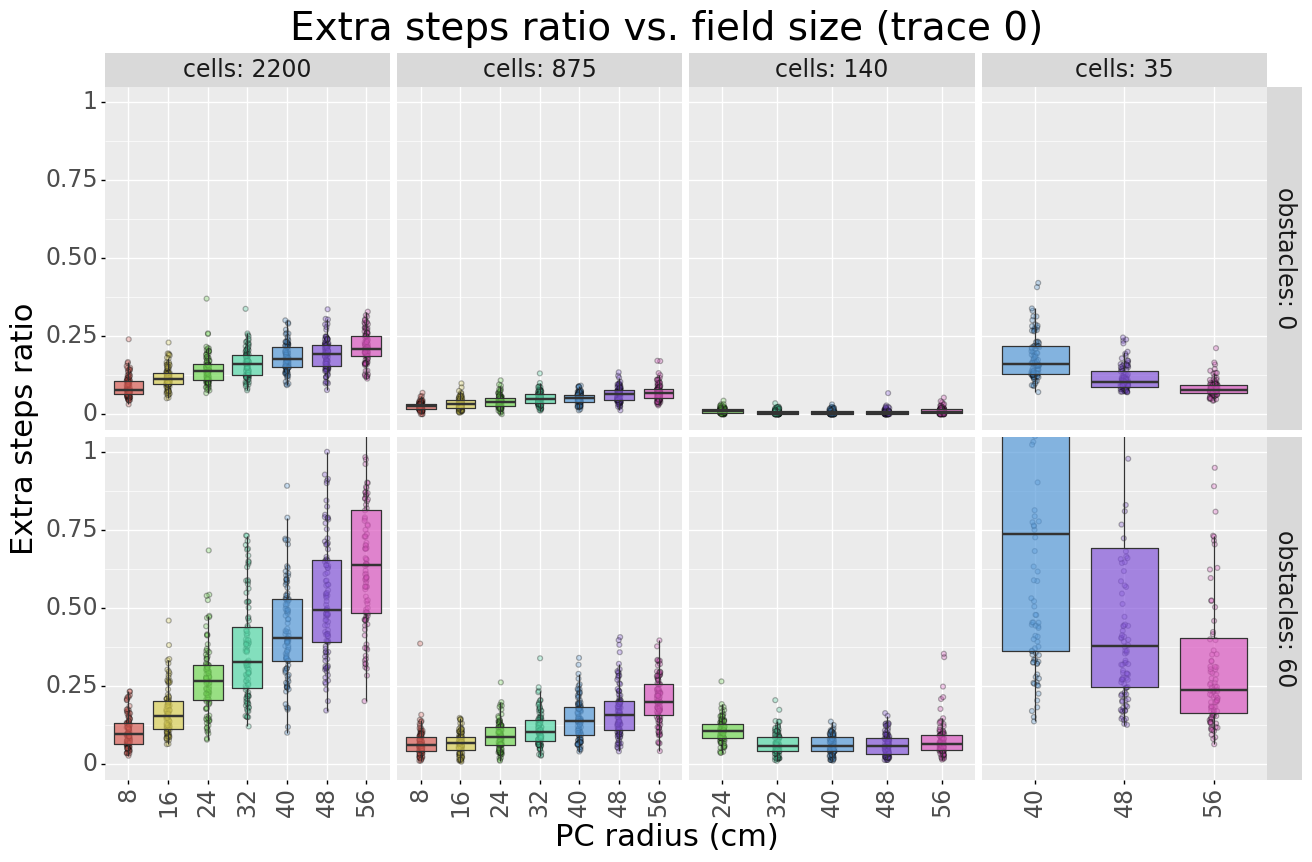

<ggplot: (116551115355)>

In [21]:
# counts = learning_times['number of cells'].value_counts()
plot_title = f'Extra steps ratio vs. field size (trace {int(t*10)})'
x_title = f'PC radius (cm)'
y_title = f'Extra steps ratio'
fill_title = f'PC radius (cm)'

plot_data = runtimes_last_episode[runtimes_last_episode.scale > 4]
plot_data = plot_data[ (plot_data['number of cells'].isin({2200, 875, 140, 35})) & (plot_data.num_obstacles.isin({0, 60}))]
plot_data = plot_data.copy()
# filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
plot_data['scale_d'] = pd.Categorical(plot_data['scale'], np.sort(plot_data['scale'].unique())) 
plot_data['cells'] = pd.Categorical(plot_data['number of cells'], np.sort(plot_data['number of cells'].unique())[::-1])
plot_data['obstacles'] = plot_data.num_obstacles

save_name = f'e1_extra_steps_by_obstacles_and_cellsMST'


def do_plot():
    p = ggplot(plot_data, aes('scale_d', 'steps', fill='scale_d' ))
    p += facet_grid(f'obstacles ~ cells', scales='free_x', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group='scale_d'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x=x_title, y=y_title, title=plot_title, fill=fill_title)
    p += coord_cartesian(ylim=[0, 1])
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(im_width, im_height)
    )
    return p


im_width, im_height = 15, 9
p = do_plot()



%matplotlib inline

# plt.rcParams['figure.figsize'] = [im_width, im_height]
ggsave(p, folder_article_figures + save_name + 'pdf', dpi=300, verbose = False)
ggsave(p, folder_article_figures + save_name + 'png', dpi=300, verbose = False)

display(p)

## Extra steps ratio by obstacles and scale

[8, 32, 48]
Categories (3, int64): [8, 32, 48]

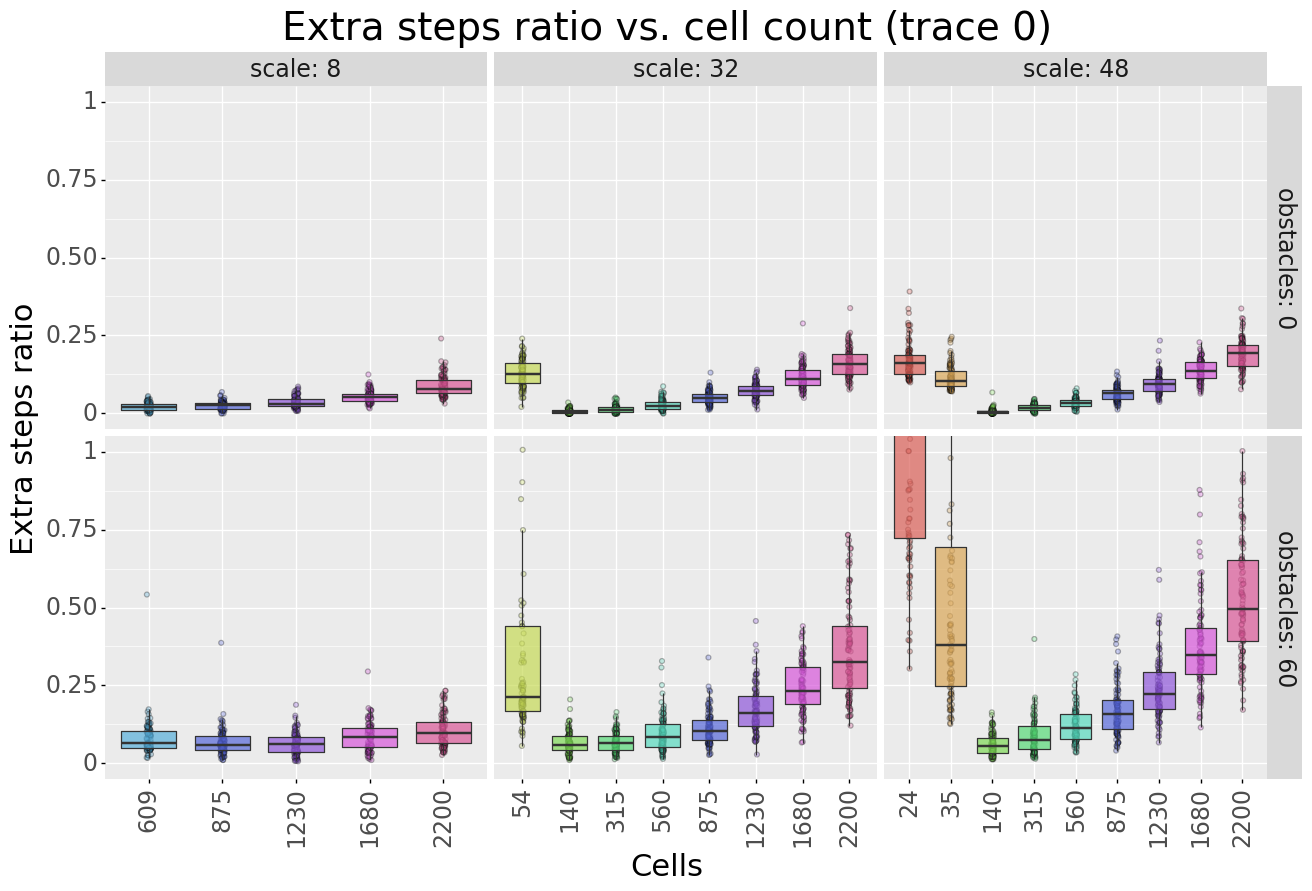

<ggplot: (116549134180)>

In [24]:
# counts = learning_times['number of cells'].value_counts()
plot_title = f'Extra steps ratio vs. cell count (trace {int(t*10)})'
x_title = f'Cells'
y_title = f'Extra steps ratio'
fill_title = f'Cells'

plot_data = runtimes_last_episode[runtimes_last_episode.scale > 4]
plot_data = plot_data[ (plot_data['scale'].isin({8, 32, 48})) & (plot_data.num_obstacles.isin({0, 60}))]
plot_data = plot_data.copy()
# filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
plot_data['scale'] = pd.Categorical(plot_data['scale'], np.sort(plot_data['scale'].unique())) 
plot_data['cells'] = pd.Categorical(plot_data['number of cells'], np.sort(plot_data['number of cells'].unique())[::1])
plot_data['obstacles'] = plot_data.num_obstacles

save_name =  f'e1_extra_steps_by_obstacles_and_scalesMST'


def do_plot():
    p = ggplot(plot_data, aes('cells', 'steps', fill='cells' ))
    p += facet_grid(f'obstacles ~ scale', scales='free_x', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group='cells'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x=x_title, y=y_title, title=plot_title, fill=fill_title)
    p += coord_cartesian(ylim=[0, 1])
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(im_width, im_height)
    )
    return p


im_width, im_height = 15, 9
p = do_plot()



%matplotlib inline

# # plt.rcParams['figure.figsize'] = [im_width, im_height]
ggsave(p, folder_article_figures + save_name + '.pdf', dpi=300, verbose = False)
ggsave(p, folder_article_figures + save_name + '.png', dpi=300, verbose = False)

display(plot_data.scale.unique())
display(p)


## Extra steps ratio by cells and scale

[8, 32, 56]
Categories (3, int64): [8, 32, 56]

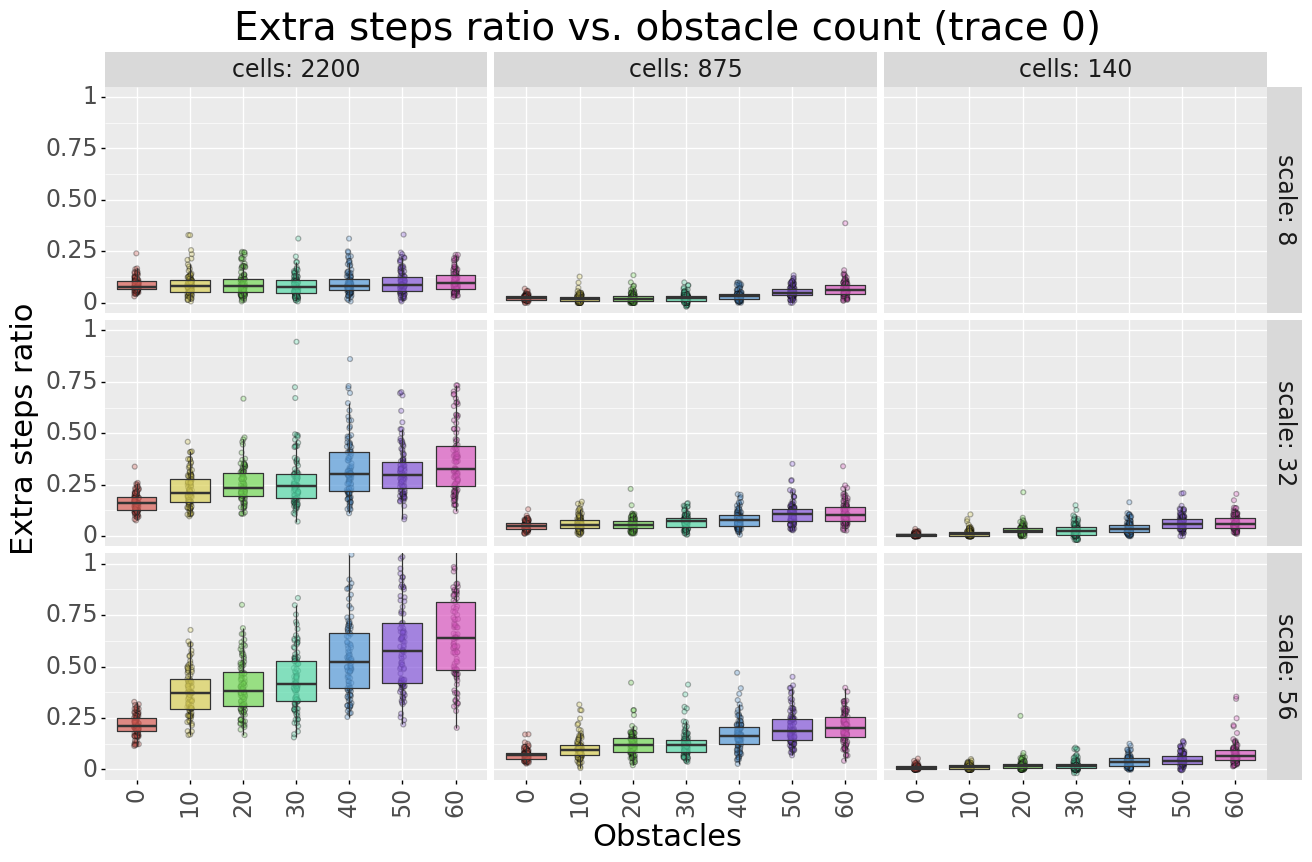

<ggplot: (116549137318)>

In [25]:
# counts = learning_times['number of cells'].value_counts()
plot_title = f'Extra steps ratio vs. obstacle count (trace {int(t*10)})'
x_title = f'Obstacles'
y_title = f'Extra steps ratio'
fill_title = x_title

plot_data = runtimes_last_episode[runtimes_last_episode.scale > 4]
plot_data = plot_data[ (plot_data['scale'].isin({8, 32, 56}) & plot_data['number of cells'].isin({2200, 875, 140}))]
plot_data = plot_data.copy().reset_index(drop=True)
# filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
plot_data['scale'] = pd.Categorical(plot_data['scale'], np.sort(plot_data['scale'].unique())) 
plot_data['cells'] = pd.Categorical(plot_data['number of cells'], np.sort(plot_data['number of cells'].unique())[::-1])
plot_data['obstacles'] = pd.Categorical(plot_data.num_obstacles, np.sort(plot_data['num_obstacles'].unique()))

save_name =  f'e1_extra_steps_by_cells_and_scaleMST'



def do_plot():
    p = ggplot(plot_data, aes('obstacles', 'steps', fill='obstacles' ))
    p += facet_grid(f'scale ~ cells', scales='free_x', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group='obstacles'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x=x_title, y=y_title, title=plot_title, fill=fill_title)
    p += coord_cartesian(ylim=[0, 1])
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(im_width, im_height)
    )
    return p


im_width, im_height = 15, 9
p = do_plot()



%matplotlib inline

# # plt.rcParams['figure.figsize'] = [im_width, im_height]
ggsave(p, folder_article_figures + save_name + '.pdf', dpi=300, verbose = False)
ggsave(p, folder_article_figures + save_name + '.png', dpi=300, verbose = False)

display(plot_data.scale.unique())
display(p)
# display(learning_times.num_obstacles.unique())


## Plot mazes

'M1_u'

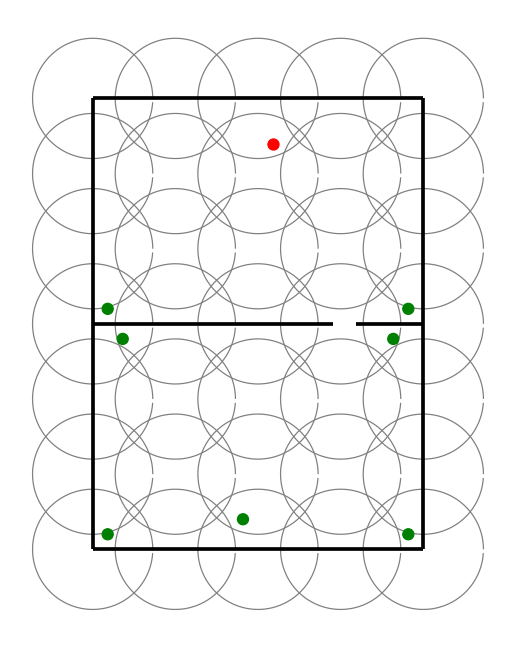

<ggplot: (115832963702)>

'M1_lu0'

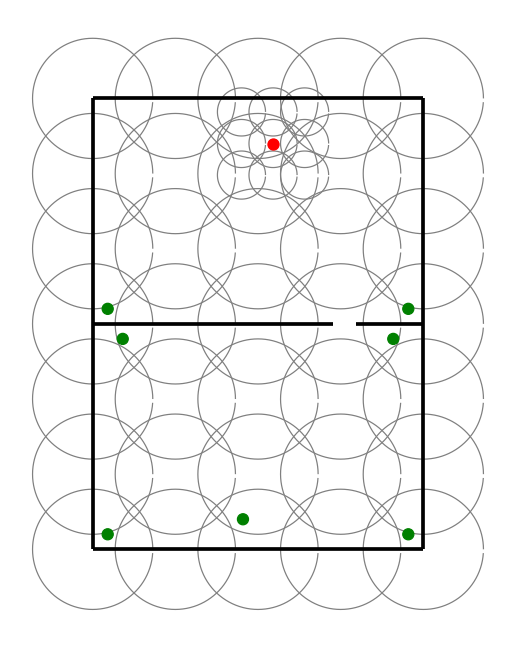

<ggplot: (115833153723)>

In [103]:
folder_mazes = 'experiments/mazes/' 
folder_layers = 'experiments/pc_layers/'

pc_files = [
    #'uniform/u20_10',
    #'uniform/u40_10',
    #'uniform/u20_15',
    #'uniform/u40_15',
    #'multi_layer/ml_4_16_52',
    #'multi_layer/ml_4_16_52',
    'uniform/u40_05',
    # 'locally_uniform/lu0_40_16',
    'locally_uniform/lu0_40_16',
    # 'locally_uniform/lu1_40_16',
    # 'non_uniform/non_uniform_0',
    # 'non_uniform/non_uniform_1',
    # 'non_uniform/non_uniform_8',
]
maze_files = [
    #'obstacles/M100',
    #'obstacles/M200',
    #'obstacles/M300',
    #'obstacles/M400',
    #'obstacles/M500',
    #'obstacles/M600',
    'M1',
    # 'M0',
    'M1',
    # 'M1',
    # 'M0',
    # 'M1',
    # 'M8'
]

save_names = [
    #'M100_u20_10',
    #'M200_u40_15',
    #'M300_u20_15',
    #'M400_u40_15',
    #'M500_ml',
    #'M600_ml',
    'M1_u',
    # 'M0_lu0',
    'M1_lu0',
    # 'M1_lu1',
    # 'M0_nu',
    # 'M1_nu',
    # 'M2_nu'
]


thetas = np.arange(100)/100*2*np.pi
unit_circle = pd.DataFrame({'x':np.cos(thetas),'y':np.sin(thetas)})
def draw_circle(x,y,r, **kwargs):
    circle = unit_circle*r + [x,y]
    return geom_path(aes(x='x',y='y'), data=circle, **kwargs)


for (p_file, m_file, s_name) in zip(pc_files, maze_files, save_names):

    walls, feeders, start_positions = parse_maze(folder_mazes + m_file + '.xml')
    pcs = pd.read_csv(folder_layers + p_file + '.csv')

    p = ggplot()
    for id, pc in pcs.iterrows():
        p += draw_circle(pc['x'], pc['y'], pc['r'], color='gray')
    p += geom_segment(aes(x='x1', y='y1', xend='x2', yend='y2'), data=walls, color='k', size=1.5)
    p += geom_point(aes(x='x', y='y'), data=feeders, color='r', size=4)
    p += geom_point(aes(x='x', y='y'), data=start_positions, color='g', size=4)
    p += coord_fixed(ratio = 1)
    p += theme_void()

    display(s_name)
    display(p)
    
    ggsave(p, folder_maze_figures + s_name + '.png', dpi=300, verbose = False)
    
